In [1]:
from typing import List, Tuple, Dict, Union, Optional
import prolif as plf
import glob
import datamol as dm
import os
import rdkit.Chem as Chem
import seaborn as sns

from src.data.datasets import load_protein_from_pdb, load_sdf
from src.data.datasets import get_dataset
from src.utils.prolif import (
    generate_interaction_df,
    merge_interaction_dfs,
    calculate_interaction_similarity,
)
from src.data.datasets import *
from tqdm import tqdm
import openbabel as ob

In [2]:
def get_pdbqt_mol(pdbqt_block):
    """Convert pdbqt block to rdkit mol by converting with openbabel"""
    # write pdbqt file
    with open("test_pdbqt.pdbqt", "w") as f:
        f.write(pdbqt_block)

    # read pdbqt file from autodock
    mol = ob.OBMol()
    obConversion = ob.OBConversion()
    obConversion.SetInAndOutFormats("pdbqt", "pdb")
    obConversion.ReadFile(mol, "test_pdbqt.pdbqt")

    # convert to RDKIT
    mol = Chem.MolFromPDBBlock(obConversion.WriteString(mol))
    return mol


def read_pdbqt(pdbqt_file):
    """Read pdbqt file from autodock"""
    with open(pdbqt_file, "r") as f:
        pdbqt_block = f.read()
    return get_pdbqt_mol(pdbqt_block)

In [15]:
class DiffSBDDSamples(BasePosesDataset):
    def __init__(
        self,
        docked,
        diffsbdd_dir="/Users/charlie/projects/poses_benchmark/data/benchmarks/diffsbdd/",
        *args,
        **kwargs,
    ):
        super().__init__(*args, **kwargs)
        self.name = "diffsbdd"
        self.docked = docked
        self.ligand_dir = diffsbdd_dir

    def __repr__(self) -> str:
        return f"{self.name}_{'docked' if self.docked else 'generated'}"

    def load_generated_mols(self, idx: int = 0):
        name = self.names[idx]
        pdbqt_files = glob.glob(self.ligand_dir + f"*{name}*" + "*.pdbqt")
        pdbqt_files = [
            pdbqt_file for pdbqt_file in pdbqt_files if "out" not in pdbqt_file
        ]
        generated_mols = [read_pdbqt(pdbqt_file) for pdbqt_file in pdbqt_files]
        return generated_mols

    def load_docked_mols(self, idx: int = 0):
        name = self.names[idx]
        pdbqt_files = glob.glob(self.ligand_dir + f"*{name}*" + "*.pdbqt")
        pdbqt_files = [
            pdbqt_file for pdbqt_file in pdbqt_files if "out" not in pdbqt_file
        ]

        docked_paths = [
            pdbqt_file.split(".")[0] + "_out.pdbqt" for pdbqt_file in pdbqt_files
        ]
        docked_mols = [read_pdbqt(pdbqt_file) for pdbqt_file in docked_paths]
        return docked_mols

    def load_mols(self, idx: int = 0):
        if self.docked:
            return self.load_docked_mols(idx)
        elif not self.docked:
            return self.load_generated_mols(idx)

    def prepare_sdf(self, name: str, idx: int = 0):
        mols = self.load_mols(idx)

        # Remove None values
        mols = [dm.add_hs(mol, add_coords=True) for mol in mols if mol is not None]

        tmp_path = self.ligand_dir + "tmp.sdf"
        dm.to_sdf(mols, tmp_path)

        try:
            lig = load_mols_from_sdf(tmp_path)
            os.remove(tmp_path)
            return lig
        except Exception as e:
            print(e)
            return []

In [27]:
dataset_docked = DiffSBDDSamples(docked=True)


dataset_generated = DiffSBDDSamples(docked=False)

dataset_docked.all_interactions
dataset_generated.all_interactions

dataset_docked.all_clashes
dataset_generated.all_clashes

Calculating interactions...


diffsbdd_docked:   0%|          | 0/100 [00:00<?, ?it/s]==============================
*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is =)

*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is =)

[16:57:14] Explicit valence for atom # 6 O, 3, is greater than permitted
[16:57:14] Explicit valence for atom # 22 O, 3, is greater than permitted
*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is =)

[16:57:14] Explicit valence for atom # 18 O, 3, is greater than permitted
[16:57:14] Explicit valence for atom # 8 C, 5, is greater than permitted
[16:57:14] Explicit valence for atom # 28 F, 2, is greater than permitted
*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is =)

[16:57:14] Explicit valence for atom # 0 O, 3

  0%|          | 0/89 [00:00<?, ?it/s]

diffsbdd_docked:   1%|          | 1/100 [00:06<09:56,  6.02s/it]/Users/charlie/opt/anaconda3/envs/poses/lib/python3.11/site-packages/openbabel/__init__.py:14: UserWarning: "import openbabel" is deprecated, instead use "from openbabel import openbabel"
  warnings.warn('"import openbabel" is deprecated, instead use "from openbabel import openbabel"')
*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is =)

[16:57:20] Explicit valence for atom # 11 C, 5, is greater than permitted
[16:57:20] Explicit valence for atom # 1 C, 5, is greater than permitted
*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is =)

*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is =)

*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is =)

**

  0%|          | 0/96 [00:00<?, ?it/s]

diffsbdd_docked:   2%|▏         | 2/100 [00:12<10:24,  6.37s/it]/Users/charlie/opt/anaconda3/envs/poses/lib/python3.11/site-packages/openbabel/__init__.py:14: UserWarning: "import openbabel" is deprecated, instead use "from openbabel import openbabel"
  warnings.warn('"import openbabel" is deprecated, instead use "from openbabel import openbabel"')
*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is =)

*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is =)

[16:57:27] Explicit valence for atom # 1 O, 3, is greater than permitted
[16:57:27] Explicit valence for atom # 1 F, 2, is greater than permitted
*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is =)

*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is =)

***

  0%|          | 0/98 [00:00<?, ?it/s]

diffsbdd_docked:   3%|▎         | 3/100 [00:24<14:16,  8.83s/it]/Users/charlie/opt/anaconda3/envs/poses/lib/python3.11/site-packages/openbabel/__init__.py:14: UserWarning: "import openbabel" is deprecated, instead use "from openbabel import openbabel"
  warnings.warn('"import openbabel" is deprecated, instead use "from openbabel import openbabel"')
[16:57:39] Explicit valence for atom # 7 O, 3, is greater than permitted
[16:57:39] Explicit valence for atom # 5 C, 5, is greater than permitted
[16:57:39] Explicit valence for atom # 31 O, 3, is greater than permitted
*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is =)

*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is =)

*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is =)

*** Open Babel Warning  in PerceiveBondOrders
  Failed

  0%|          | 0/97 [00:00<?, ?it/s]

diffsbdd_docked:   4%|▍         | 4/100 [00:28<11:27,  7.16s/it]/Users/charlie/opt/anaconda3/envs/poses/lib/python3.11/site-packages/openbabel/__init__.py:14: UserWarning: "import openbabel" is deprecated, instead use "from openbabel import openbabel"
  warnings.warn('"import openbabel" is deprecated, instead use "from openbabel import openbabel"')
*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is =)

*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is =)

*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is =)

*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is =)

*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is =)

*** Open Babel Warning  

  0%|          | 0/97 [00:00<?, ?it/s]

diffsbdd_docked:   5%|▌         | 5/100 [00:34<10:40,  6.74s/it]/Users/charlie/opt/anaconda3/envs/poses/lib/python3.11/site-packages/openbabel/__init__.py:14: UserWarning: "import openbabel" is deprecated, instead use "from openbabel import openbabel"
  warnings.warn('"import openbabel" is deprecated, instead use "from openbabel import openbabel"')
*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is =)

[16:57:49] Explicit valence for atom # 14 O, 3, is greater than permitted
[16:57:49] Explicit valence for atom # 5 O, 3, is greater than permitted
[16:57:49] Explicit valence for atom # 12 O, 3, is greater than permitted
[16:57:49] Explicit valence for atom # 14 O, 3, is greater than permitted
[16:57:49] Explicit valence for atom # 0 C, 5, is greater than permitted
*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is =)

[16:57:49] Explicit valence for

  0%|          | 0/92 [00:00<?, ?it/s]

diffsbdd_docked:   6%|▌         | 6/100 [00:39<09:31,  6.08s/it]/Users/charlie/opt/anaconda3/envs/poses/lib/python3.11/site-packages/openbabel/__init__.py:14: UserWarning: "import openbabel" is deprecated, instead use "from openbabel import openbabel"
  warnings.warn('"import openbabel" is deprecated, instead use "from openbabel import openbabel"')
*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is =)

*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is =)

[16:57:54] Explicit valence for atom # 20 C, 5, is greater than permitted
*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is =)

*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is =)

[16:57:54] Explicit valence for atom # 9 C, 5, is greater than permitted
**

  0%|          | 0/93 [00:00<?, ?it/s]

diffsbdd_docked:   7%|▋         | 7/100 [00:45<09:15,  5.97s/it]/Users/charlie/opt/anaconda3/envs/poses/lib/python3.11/site-packages/openbabel/__init__.py:14: UserWarning: "import openbabel" is deprecated, instead use "from openbabel import openbabel"
  warnings.warn('"import openbabel" is deprecated, instead use "from openbabel import openbabel"')
*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is =)

[16:58:00] Explicit valence for atom # 10 C, 5, is greater than permitted
*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is =)

[16:58:00] Explicit valence for atom # 26 O, 3, is greater than permitted
[16:58:00] Explicit valence for atom # 5 F, 3, is greater than permitted
[16:58:00] Explicit valence for atom # 38 F, 3, is greater than permitted
*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBond

  0%|          | 0/93 [00:00<?, ?it/s]

diffsbdd_docked:   8%|▊         | 8/100 [00:58<12:31,  8.17s/it]/Users/charlie/opt/anaconda3/envs/poses/lib/python3.11/site-packages/openbabel/__init__.py:14: UserWarning: "import openbabel" is deprecated, instead use "from openbabel import openbabel"
  warnings.warn('"import openbabel" is deprecated, instead use "from openbabel import openbabel"')
*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is =)

*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is =)

*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is =)

[16:58:13] Explicit valence for atom # 2 C, 5, is greater than permitted
[16:58:13] Explicit valence for atom # 22 O, 3, is greater than permitted
*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is =)

[1

  0%|          | 0/96 [00:00<?, ?it/s]

diffsbdd_docked:   9%|▉         | 9/100 [01:03<10:55,  7.20s/it]/Users/charlie/opt/anaconda3/envs/poses/lib/python3.11/site-packages/openbabel/__init__.py:14: UserWarning: "import openbabel" is deprecated, instead use "from openbabel import openbabel"
  warnings.warn('"import openbabel" is deprecated, instead use "from openbabel import openbabel"')
*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is =)

[16:58:18] Explicit valence for atom # 3 C, 5, is greater than permitted
[16:58:18] Explicit valence for atom # 16 O, 3, is greater than permitted
[16:58:18] Explicit valence for atom # 22 O, 3, is greater than permitted
*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is =)

*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is =)

*** Open Babel Warning  in PerceiveBondOrders
  Faile

  0%|          | 0/93 [00:00<?, ?it/s]

diffsbdd_docked:  10%|█         | 10/100 [01:08<09:39,  6.44s/it]/Users/charlie/opt/anaconda3/envs/poses/lib/python3.11/site-packages/openbabel/__init__.py:14: UserWarning: "import openbabel" is deprecated, instead use "from openbabel import openbabel"
  warnings.warn('"import openbabel" is deprecated, instead use "from openbabel import openbabel"')
*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is =)

*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is =)

*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is =)

*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is =)

[16:58:23] Explicit valence for atom # 26 O, 3, is greater than permitted
*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromati

  0%|          | 0/97 [00:00<?, ?it/s]

diffsbdd_docked:  11%|█         | 11/100 [01:19<11:41,  7.89s/it]/Users/charlie/opt/anaconda3/envs/poses/lib/python3.11/site-packages/openbabel/__init__.py:14: UserWarning: "import openbabel" is deprecated, instead use "from openbabel import openbabel"
  warnings.warn('"import openbabel" is deprecated, instead use "from openbabel import openbabel"')
*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is =)

*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is =)

*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is =)

*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is =)

[16:58:34] Explicit valence for atom # 25 O, 3, is greater than permitted
*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromati

  0%|          | 0/94 [00:00<?, ?it/s]

diffsbdd_docked:  12%|█▏        | 12/100 [01:29<12:36,  8.60s/it]/Users/charlie/opt/anaconda3/envs/poses/lib/python3.11/site-packages/openbabel/__init__.py:14: UserWarning: "import openbabel" is deprecated, instead use "from openbabel import openbabel"
  warnings.warn('"import openbabel" is deprecated, instead use "from openbabel import openbabel"')
[16:58:44] Explicit valence for atom # 11 C, 5, is greater than permitted
[16:58:44] Explicit valence for atom # 1 C, 5, is greater than permitted
[16:58:44] Explicit valence for atom # 18 C, 5, is greater than permitted
[16:58:44] Explicit valence for atom # 10 O, 3, is greater than permitted
*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is =)

[16:58:44] Explicit valence for atom # 23 O, 3, is greater than permitted
[16:58:44] Explicit valence for atom # 6 O, 3, is greater than permitted
[16:58:44] Explicit valence for atom # 0 C, 5, is greater than permitted
[16:58:4

  0%|          | 0/88 [00:00<?, ?it/s]

diffsbdd_docked:  13%|█▎        | 13/100 [01:34<10:44,  7.40s/it]/Users/charlie/opt/anaconda3/envs/poses/lib/python3.11/site-packages/openbabel/__init__.py:14: UserWarning: "import openbabel" is deprecated, instead use "from openbabel import openbabel"
  warnings.warn('"import openbabel" is deprecated, instead use "from openbabel import openbabel"')
[16:58:49] Explicit valence for atom # 1 O, 3, is greater than permitted
*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is =)

*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is =)

*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is =)

[16:58:49] Explicit valence for atom # 0 F, 2, is greater than permitted
*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is =)

**

  0%|          | 0/95 [00:00<?, ?it/s]

diffsbdd_docked:  14%|█▍        | 14/100 [01:38<09:08,  6.38s/it]/Users/charlie/opt/anaconda3/envs/poses/lib/python3.11/site-packages/openbabel/__init__.py:14: UserWarning: "import openbabel" is deprecated, instead use "from openbabel import openbabel"
  warnings.warn('"import openbabel" is deprecated, instead use "from openbabel import openbabel"')
[16:58:53] Explicit valence for atom # 0 F, 2, is greater than permitted
[16:58:53] Explicit valence for atom # 14 C, 5, is greater than permitted
[16:58:53] Explicit valence for atom # 1 C, 7, is greater than permitted
*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is =)

[16:58:53] Explicit valence for atom # 8 C, 5, is greater than permitted
*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is =)

[16:58:53] Explicit valence for atom # 8 F, 2, is greater than permitted
*** Open Babel Warning  in Perce

  0%|          | 0/71 [00:00<?, ?it/s]

diffsbdd_docked:  15%|█▌        | 15/100 [01:41<07:33,  5.33s/it]/Users/charlie/opt/anaconda3/envs/poses/lib/python3.11/site-packages/openbabel/__init__.py:14: UserWarning: "import openbabel" is deprecated, instead use "from openbabel import openbabel"
  warnings.warn('"import openbabel" is deprecated, instead use "from openbabel import openbabel"')
*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is =)

[16:58:56] Explicit valence for atom # 14 O, 3, is greater than permitted
*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is =)

*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is =)

[16:58:56] Explicit valence for atom # 22 O, 3, is greater than permitted
*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is =)



  0%|          | 0/96 [00:00<?, ?it/s]

diffsbdd_docked:  16%|█▌        | 16/100 [01:44<06:36,  4.72s/it]/Users/charlie/opt/anaconda3/envs/poses/lib/python3.11/site-packages/openbabel/__init__.py:14: UserWarning: "import openbabel" is deprecated, instead use "from openbabel import openbabel"
  warnings.warn('"import openbabel" is deprecated, instead use "from openbabel import openbabel"')
*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is =)

[16:58:59] Explicit valence for atom # 28 F, 2, is greater than permitted
*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is =)

*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is =)

*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is =)

*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromati

  0%|          | 0/88 [00:00<?, ?it/s]

diffsbdd_docked:  17%|█▋        | 17/100 [01:54<08:43,  6.31s/it]/Users/charlie/opt/anaconda3/envs/poses/lib/python3.11/site-packages/openbabel/__init__.py:14: UserWarning: "import openbabel" is deprecated, instead use "from openbabel import openbabel"
  warnings.warn('"import openbabel" is deprecated, instead use "from openbabel import openbabel"')
[16:59:09] Explicit valence for atom # 21 O, 3, is greater than permitted
*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is =)

[16:59:09] Explicit valence for atom # 15 O, 3, is greater than permitted
*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is =)

*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is =)

*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is =)



  0%|          | 0/97 [00:00<?, ?it/s]

diffsbdd_docked:  18%|█▊        | 18/100 [01:58<07:51,  5.74s/it]/Users/charlie/opt/anaconda3/envs/poses/lib/python3.11/site-packages/openbabel/__init__.py:14: UserWarning: "import openbabel" is deprecated, instead use "from openbabel import openbabel"
  warnings.warn('"import openbabel" is deprecated, instead use "from openbabel import openbabel"')
[16:59:13] Explicit valence for atom # 32 C, 5, is greater than permitted
[16:59:13] Explicit valence for atom # 15 O, 3, is greater than permitted
[16:59:13] Explicit valence for atom # 5 O, 3, is greater than permitted
[16:59:13] Explicit valence for atom # 8 O, 3, is greater than permitted
[16:59:13] Explicit valence for atom # 2 O, 3, is greater than permitted
*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is =)

[16:59:13] Explicit valence for atom # 22 O, 3, is greater than permitted
[16:59:13] Explicit valence for atom # 9 O, 3, is greater than permitted
[16:59:13

  0%|          | 0/86 [00:00<?, ?it/s]

diffsbdd_docked:  19%|█▉        | 19/100 [02:03<07:11,  5.33s/it]/Users/charlie/opt/anaconda3/envs/poses/lib/python3.11/site-packages/openbabel/__init__.py:14: UserWarning: "import openbabel" is deprecated, instead use "from openbabel import openbabel"
  warnings.warn('"import openbabel" is deprecated, instead use "from openbabel import openbabel"')
[16:59:18] Explicit valence for atom # 26 O, 3, is greater than permitted
*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is =)

[16:59:18] Explicit valence for atom # 1 F, 2, is greater than permitted
*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is =)

*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is =)

*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is =)

[

  0%|          | 0/91 [00:00<?, ?it/s]

diffsbdd_docked:  20%|██        | 20/100 [02:13<09:00,  6.75s/it]/Users/charlie/opt/anaconda3/envs/poses/lib/python3.11/site-packages/openbabel/__init__.py:14: UserWarning: "import openbabel" is deprecated, instead use "from openbabel import openbabel"
  warnings.warn('"import openbabel" is deprecated, instead use "from openbabel import openbabel"')
*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is =)

*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is =)

[16:59:28] Explicit valence for atom # 14 C, 5, is greater than permitted
*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is =)

[16:59:28] Explicit valence for atom # 6 C, 5, is greater than permitted
*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is =)

[

  0%|          | 0/97 [00:00<?, ?it/s]

diffsbdd_docked:  21%|██        | 21/100 [02:16<07:30,  5.70s/it]/Users/charlie/opt/anaconda3/envs/poses/lib/python3.11/site-packages/openbabel/__init__.py:14: UserWarning: "import openbabel" is deprecated, instead use "from openbabel import openbabel"
  warnings.warn('"import openbabel" is deprecated, instead use "from openbabel import openbabel"')
*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is =)

*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is =)

*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is =)

*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is =)

[16:59:31] Explicit valence for atom # 27 O, 3, is greater than permitted
[16:59:31] Explicit valence for atom # 20 C, 5, is greater than permitted


  0%|          | 0/97 [00:00<?, ?it/s]

diffsbdd_docked:  22%|██▏       | 22/100 [02:20<06:49,  5.25s/it]/Users/charlie/opt/anaconda3/envs/poses/lib/python3.11/site-packages/openbabel/__init__.py:14: UserWarning: "import openbabel" is deprecated, instead use "from openbabel import openbabel"
  warnings.warn('"import openbabel" is deprecated, instead use "from openbabel import openbabel"')
*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is =)

*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is =)

[16:59:35] Explicit valence for atom # 1 O, 3, is greater than permitted
[16:59:35] Explicit valence for atom # 26 C, 5, is greater than permitted
*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is =)

*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is =)

[

  0%|          | 0/85 [00:00<?, ?it/s]

diffsbdd_docked:  23%|██▎       | 23/100 [02:32<09:05,  7.08s/it]/Users/charlie/opt/anaconda3/envs/poses/lib/python3.11/site-packages/openbabel/__init__.py:14: UserWarning: "import openbabel" is deprecated, instead use "from openbabel import openbabel"
  warnings.warn('"import openbabel" is deprecated, instead use "from openbabel import openbabel"')
[16:59:47] Explicit valence for atom # 26 C, 5, is greater than permitted
*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is =)

[16:59:47] Explicit valence for atom # 25 F, 2, is greater than permitted
*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is =)

*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is =)

[16:59:47] Explicit valence for atom # 5 O, 3, is greater than permitted
*** Open Babel Warning  in PerceiveBondOrders
  Fail

  0%|          | 0/85 [00:00<?, ?it/s]

diffsbdd_docked:  24%|██▍       | 24/100 [02:35<07:43,  6.10s/it]/Users/charlie/opt/anaconda3/envs/poses/lib/python3.11/site-packages/openbabel/__init__.py:14: UserWarning: "import openbabel" is deprecated, instead use "from openbabel import openbabel"
  warnings.warn('"import openbabel" is deprecated, instead use "from openbabel import openbabel"')
*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is =)

*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is =)

[16:59:50] Explicit valence for atom # 30 O, 3, is greater than permitted
[16:59:50] Explicit valence for atom # 8 C, 5, is greater than permitted
*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is =)

[16:59:50] Explicit valence for atom # 4 C, 5, is greater than permitted
*** Open Babel Warning  in PerceiveBondOrders
  Faile

  0%|          | 0/94 [00:00<?, ?it/s]

diffsbdd_docked:  25%|██▌       | 25/100 [02:40<07:07,  5.69s/it]/Users/charlie/opt/anaconda3/envs/poses/lib/python3.11/site-packages/openbabel/__init__.py:14: UserWarning: "import openbabel" is deprecated, instead use "from openbabel import openbabel"
  warnings.warn('"import openbabel" is deprecated, instead use "from openbabel import openbabel"')
[16:59:55] Explicit valence for atom # 20 F, 2, is greater than permitted
*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is =)

*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is =)

[16:59:55] Explicit valence for atom # 1 O, 3, is greater than permitted
*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is =)

*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is =)

[

  0%|          | 0/93 [00:00<?, ?it/s]

diffsbdd_docked:  26%|██▌       | 26/100 [02:44<06:27,  5.24s/it]/Users/charlie/opt/anaconda3/envs/poses/lib/python3.11/site-packages/openbabel/__init__.py:14: UserWarning: "import openbabel" is deprecated, instead use "from openbabel import openbabel"
  warnings.warn('"import openbabel" is deprecated, instead use "from openbabel import openbabel"')
*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is =)

*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is =)

*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is =)

*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is =)

*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is =)

*** Open Babel Warning 

  0%|          | 0/93 [00:00<?, ?it/s]

diffsbdd_docked:  27%|██▋       | 27/100 [02:55<08:20,  6.85s/it]/Users/charlie/opt/anaconda3/envs/poses/lib/python3.11/site-packages/openbabel/__init__.py:14: UserWarning: "import openbabel" is deprecated, instead use "from openbabel import openbabel"
  warnings.warn('"import openbabel" is deprecated, instead use "from openbabel import openbabel"')
*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is =)

*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is =)

*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is =)

[17:00:10] Explicit valence for atom # 15 O, 3, is greater than permitted
*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is =)

*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromati

  0%|          | 0/92 [00:00<?, ?it/s]

diffsbdd_docked:  28%|██▊       | 28/100 [03:00<07:24,  6.17s/it]/Users/charlie/opt/anaconda3/envs/poses/lib/python3.11/site-packages/openbabel/__init__.py:14: UserWarning: "import openbabel" is deprecated, instead use "from openbabel import openbabel"
  warnings.warn('"import openbabel" is deprecated, instead use "from openbabel import openbabel"')
[17:00:14] Explicit valence for atom # 3 C, 5, is greater than permitted
*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is =)

*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is =)

[17:00:14] Explicit valence for atom # 0 F, 2, is greater than permitted
*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is =)

*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is =)

**

  0%|          | 0/96 [00:00<?, ?it/s]

diffsbdd_docked:  29%|██▉       | 29/100 [03:03<06:15,  5.29s/it]/Users/charlie/opt/anaconda3/envs/poses/lib/python3.11/site-packages/openbabel/__init__.py:14: UserWarning: "import openbabel" is deprecated, instead use "from openbabel import openbabel"
  warnings.warn('"import openbabel" is deprecated, instead use "from openbabel import openbabel"')
*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is =)

[17:00:18] Explicit valence for atom # 5 C, 5, is greater than permitted
[17:00:18] Explicit valence for atom # 6 C, 5, is greater than permitted
[17:00:18] Explicit valence for atom # 6 O, 3, is greater than permitted
*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is =)

[17:00:18] Explicit valence for atom # 24 O, 3, is greater than permitted


  0%|          | 0/96 [00:00<?, ?it/s]

diffsbdd_docked:  30%|███       | 30/100 [03:07<05:45,  4.94s/it]/Users/charlie/opt/anaconda3/envs/poses/lib/python3.11/site-packages/openbabel/__init__.py:14: UserWarning: "import openbabel" is deprecated, instead use "from openbabel import openbabel"
  warnings.warn('"import openbabel" is deprecated, instead use "from openbabel import openbabel"')
[17:00:22] Explicit valence for atom # 18 C, 5, is greater than permitted
[17:00:22] Explicit valence for atom # 6 F, 2, is greater than permitted
[17:00:22] Explicit valence for atom # 6 O, 4, is greater than permitted
*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is =)

[17:00:22] Explicit valence for atom # 17 O, 3, is greater than permitted
[17:00:22] Explicit valence for atom # 19 O, 3, is greater than permitted
[17:00:22] Explicit valence for atom # 17 C, 5, is greater than permitted
[17:00:22] Explicit valence for atom # 11 O, 3, is greater than permitted
*** Ope

  0%|          | 0/86 [00:00<?, ?it/s]

diffsbdd_docked:  31%|███       | 31/100 [03:11<05:27,  4.75s/it]/Users/charlie/opt/anaconda3/envs/poses/lib/python3.11/site-packages/openbabel/__init__.py:14: UserWarning: "import openbabel" is deprecated, instead use "from openbabel import openbabel"
  warnings.warn('"import openbabel" is deprecated, instead use "from openbabel import openbabel"')
*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is =)

*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is =)

*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is =)

*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is =)

[17:00:26] Explicit valence for atom # 16 O, 3, is greater than permitted
[17:00:26] Explicit valence for atom # 9 O, 3, is greater than permitted
*

  0%|          | 0/93 [00:00<?, ?it/s]

diffsbdd_docked:  32%|███▏      | 32/100 [03:22<07:28,  6.59s/it]/Users/charlie/opt/anaconda3/envs/poses/lib/python3.11/site-packages/openbabel/__init__.py:14: UserWarning: "import openbabel" is deprecated, instead use "from openbabel import openbabel"
  warnings.warn('"import openbabel" is deprecated, instead use "from openbabel import openbabel"')
*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is =)

*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is =)

[17:00:37] Explicit valence for atom # 11 O, 3, is greater than permitted
*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is =)

[17:00:37] Explicit valence for atom # 12 O, 3, is greater than permitted
[17:00:37] Explicit valence for atom # 11 O, 3, is greater than permitted
[17:00:37] Explicit valence for atom # 24 O, 3, is 

  0%|          | 0/91 [00:00<?, ?it/s]

diffsbdd_docked:  33%|███▎      | 33/100 [03:27<06:41,  5.99s/it]/Users/charlie/opt/anaconda3/envs/poses/lib/python3.11/site-packages/openbabel/__init__.py:14: UserWarning: "import openbabel" is deprecated, instead use "from openbabel import openbabel"
  warnings.warn('"import openbabel" is deprecated, instead use "from openbabel import openbabel"')
*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is =)

*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is =)

[17:00:42] Explicit valence for atom # 28 O, 3, is greater than permitted
*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is =)

*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is =)

[17:00:42] Explicit valence for atom # 25 O, 4, is greater than permitted


  0%|          | 0/94 [00:00<?, ?it/s]

diffsbdd_docked:  34%|███▍      | 34/100 [03:31<05:55,  5.38s/it]/Users/charlie/opt/anaconda3/envs/poses/lib/python3.11/site-packages/openbabel/__init__.py:14: UserWarning: "import openbabel" is deprecated, instead use "from openbabel import openbabel"
  warnings.warn('"import openbabel" is deprecated, instead use "from openbabel import openbabel"')
[17:00:46] Explicit valence for atom # 27 C, 5, is greater than permitted
*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is =)

[17:00:46] Explicit valence for atom # 36 O, 3, is greater than permitted
*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is =)

[17:00:46] Explicit valence for atom # 14 C, 5, is greater than permitted
*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is =)

[17:00:46] Explicit valence for atom # 9 F, 2, is g

  0%|          | 0/96 [00:00<?, ?it/s]

diffsbdd_docked:  35%|███▌      | 35/100 [03:34<05:13,  4.83s/it]/Users/charlie/opt/anaconda3/envs/poses/lib/python3.11/site-packages/openbabel/__init__.py:14: UserWarning: "import openbabel" is deprecated, instead use "from openbabel import openbabel"
  warnings.warn('"import openbabel" is deprecated, instead use "from openbabel import openbabel"')
[17:00:49] Explicit valence for atom # 5 F, 2, is greater than permitted
[17:00:49] Explicit valence for atom # 2 O, 3, is greater than permitted
[17:00:49] Explicit valence for atom # 14 O, 3, is greater than permitted
[17:00:49] Explicit valence for atom # 17 O, 3, is greater than permitted
[17:00:49] Explicit valence for atom # 11 C, 5, is greater than permitted
[17:00:49] Explicit valence for atom # 9 O, 3, is greater than permitted
[17:00:49] Explicit valence for atom # 17 O, 3, is greater than permitted
[17:00:49] Explicit valence for atom # 30 O, 3, is greater than permitted
[17:00:49] Explicit valence for atom # 3 O, 3, is greater t

  0%|          | 0/85 [00:00<?, ?it/s]

diffsbdd_docked:  36%|███▌      | 36/100 [03:38<04:43,  4.43s/it]/Users/charlie/opt/anaconda3/envs/poses/lib/python3.11/site-packages/openbabel/__init__.py:14: UserWarning: "import openbabel" is deprecated, instead use "from openbabel import openbabel"
  warnings.warn('"import openbabel" is deprecated, instead use "from openbabel import openbabel"')
[17:00:53] Explicit valence for atom # 17 O, 3, is greater than permitted
[17:00:53] Explicit valence for atom # 9 O, 3, is greater than permitted
*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is =)

*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is =)

[17:00:53] Explicit valence for atom # 25 O, 3, is greater than permitted
[17:00:53] Explicit valence for atom # 24 C, 5, is greater than permitted
[17:00:53] Explicit valence for atom # 4 O, 3, is greater than permitted
[17:00:53] Explicit valence fo

  0%|          | 0/87 [00:00<?, ?it/s]

diffsbdd_docked:  37%|███▋      | 37/100 [03:44<05:04,  4.83s/it]/Users/charlie/opt/anaconda3/envs/poses/lib/python3.11/site-packages/openbabel/__init__.py:14: UserWarning: "import openbabel" is deprecated, instead use "from openbabel import openbabel"
  warnings.warn('"import openbabel" is deprecated, instead use "from openbabel import openbabel"')
*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is =)

*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is =)

[17:00:58] Explicit valence for atom # 9 C, 5, is greater than permitted
*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is =)

*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is =)

*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic

  0%|          | 0/95 [00:00<?, ?it/s]

diffsbdd_docked:  38%|███▊      | 38/100 [03:49<05:13,  5.06s/it]/Users/charlie/opt/anaconda3/envs/poses/lib/python3.11/site-packages/openbabel/__init__.py:14: UserWarning: "import openbabel" is deprecated, instead use "from openbabel import openbabel"
  warnings.warn('"import openbabel" is deprecated, instead use "from openbabel import openbabel"')
[17:01:04] Explicit valence for atom # 12 O, 3, is greater than permitted
*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is =)

[17:01:04] Explicit valence for atom # 8 C, 5, is greater than permitted
*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is =)

[17:01:04] Explicit valence for atom # 14 F, 2, is greater than permitted
[17:01:04] Explicit valence for atom # 1 Br, 2, is greater than permitted
[17:01:04] Explicit valence for atom # 5 F, 2, is greater than permitted
[17:01:04] Explicit valence fo

  0%|          | 0/91 [00:00<?, ?it/s]

diffsbdd_docked:  39%|███▉      | 39/100 [03:52<04:36,  4.54s/it]/Users/charlie/opt/anaconda3/envs/poses/lib/python3.11/site-packages/openbabel/__init__.py:14: UserWarning: "import openbabel" is deprecated, instead use "from openbabel import openbabel"
  warnings.warn('"import openbabel" is deprecated, instead use "from openbabel import openbabel"')
[17:01:07] Explicit valence for atom # 22 F, 2, is greater than permitted
*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is =)

*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is =)

*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is =)

[17:01:07] Explicit valence for atom # 6 O, 3, is greater than permitted
[17:01:07] Explicit valence for atom # 1 C, 5, is greater than permitted
*** Open Babel Warning  in PerceiveBondOrders
  Faile

  0%|          | 0/88 [00:00<?, ?it/s]

diffsbdd_docked:  40%|████      | 40/100 [03:57<04:39,  4.66s/it]/Users/charlie/opt/anaconda3/envs/poses/lib/python3.11/site-packages/openbabel/__init__.py:14: UserWarning: "import openbabel" is deprecated, instead use "from openbabel import openbabel"
  warnings.warn('"import openbabel" is deprecated, instead use "from openbabel import openbabel"')
[17:01:12] Explicit valence for atom # 7 O, 3, is greater than permitted
[17:01:12] Explicit valence for atom # 4 O, 3, is greater than permitted
*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is =)

[17:01:12] Explicit valence for atom # 4 F, 2, is greater than permitted
[17:01:12] Explicit valence for atom # 28 C, 5, is greater than permitted
*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is =)

*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondO

  0%|          | 0/84 [00:00<?, ?it/s]

diffsbdd_docked:  41%|████      | 41/100 [04:02<04:30,  4.58s/it]/Users/charlie/opt/anaconda3/envs/poses/lib/python3.11/site-packages/openbabel/__init__.py:14: UserWarning: "import openbabel" is deprecated, instead use "from openbabel import openbabel"
  warnings.warn('"import openbabel" is deprecated, instead use "from openbabel import openbabel"')
*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is =)

*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is =)

[17:01:17] Explicit valence for atom # 15 O, 3, is greater than permitted
[17:01:17] Explicit valence for atom # 1 C, 5, is greater than permitted
*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is =)

*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is =)

*

  0%|          | 0/96 [00:00<?, ?it/s]

diffsbdd_docked:  42%|████▏     | 42/100 [04:06<04:22,  4.53s/it]/Users/charlie/opt/anaconda3/envs/poses/lib/python3.11/site-packages/openbabel/__init__.py:14: UserWarning: "import openbabel" is deprecated, instead use "from openbabel import openbabel"
  warnings.warn('"import openbabel" is deprecated, instead use "from openbabel import openbabel"')
*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is =)

[17:01:21] Explicit valence for atom # 2 F, 2, is greater than permitted
[17:01:21] Explicit valence for atom # 5 O, 3, is greater than permitted
*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is =)

*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is =)

[17:01:21] Explicit valence for atom # 21 F, 3, is greater than permitted
*** Open Babel Warning  in PerceiveBondOrders
  Faile

  0%|          | 0/82 [00:00<?, ?it/s]

diffsbdd_docked:  43%|████▎     | 43/100 [04:17<06:09,  6.48s/it]/Users/charlie/opt/anaconda3/envs/poses/lib/python3.11/site-packages/openbabel/__init__.py:14: UserWarning: "import openbabel" is deprecated, instead use "from openbabel import openbabel"
  warnings.warn('"import openbabel" is deprecated, instead use "from openbabel import openbabel"')
*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is =)

*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is =)

*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is =)

*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is =)

*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is =)

*** Open Babel Warning 

  0%|          | 0/93 [00:00<?, ?it/s]

diffsbdd_docked:  44%|████▍     | 44/100 [04:21<05:14,  5.61s/it]/Users/charlie/opt/anaconda3/envs/poses/lib/python3.11/site-packages/openbabel/__init__.py:14: UserWarning: "import openbabel" is deprecated, instead use "from openbabel import openbabel"
  warnings.warn('"import openbabel" is deprecated, instead use "from openbabel import openbabel"')
*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is =)

[17:01:36] Explicit valence for atom # 5 O, 3, is greater than permitted
[17:01:36] Explicit valence for atom # 4 C, 5, is greater than permitted
*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is =)

[17:01:36] Explicit valence for atom # 4 O, 3, is greater than permitted
[17:01:36] Explicit valence for atom # 17 C, 5, is greater than permitted
*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondO

  0%|          | 0/92 [00:00<?, ?it/s]

diffsbdd_docked:  45%|████▌     | 45/100 [04:32<06:40,  7.28s/it]/Users/charlie/opt/anaconda3/envs/poses/lib/python3.11/site-packages/openbabel/__init__.py:14: UserWarning: "import openbabel" is deprecated, instead use "from openbabel import openbabel"
  warnings.warn('"import openbabel" is deprecated, instead use "from openbabel import openbabel"')
[17:01:47] Explicit valence for atom # 29 F, 2, is greater than permitted
*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is =)

[17:01:47] Explicit valence for atom # 8 O, 3, is greater than permitted
*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is =)

[17:01:47] Explicit valence for atom # 11 O, 3, is greater than permitted
*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is =)

*** Open Babel Warning  in PerceiveBondOrders
  Fail

  0%|          | 0/96 [00:00<?, ?it/s]

diffsbdd_docked:  46%|████▌     | 46/100 [04:36<05:43,  6.36s/it]/Users/charlie/opt/anaconda3/envs/poses/lib/python3.11/site-packages/openbabel/__init__.py:14: UserWarning: "import openbabel" is deprecated, instead use "from openbabel import openbabel"
  warnings.warn('"import openbabel" is deprecated, instead use "from openbabel import openbabel"')
*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is =)

*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is =)

[17:01:51] Explicit valence for atom # 39 C, 5, is greater than permitted
*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is =)

*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is =)

[17:01:51] Explicit valence for atom # 6 C, 5, is greater than permitted
*

  0%|          | 0/93 [00:00<?, ?it/s]

diffsbdd_docked:  47%|████▋     | 47/100 [04:40<04:59,  5.65s/it]/Users/charlie/opt/anaconda3/envs/poses/lib/python3.11/site-packages/openbabel/__init__.py:14: UserWarning: "import openbabel" is deprecated, instead use "from openbabel import openbabel"
  warnings.warn('"import openbabel" is deprecated, instead use "from openbabel import openbabel"')
*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is =)

*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is =)

*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is =)

*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is =)

*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is =)

*** Open Babel Warning 

  0%|          | 0/98 [00:00<?, ?it/s]

diffsbdd_docked:  48%|████▊     | 48/100 [04:44<04:29,  5.18s/it]/Users/charlie/opt/anaconda3/envs/poses/lib/python3.11/site-packages/openbabel/__init__.py:14: UserWarning: "import openbabel" is deprecated, instead use "from openbabel import openbabel"
  warnings.warn('"import openbabel" is deprecated, instead use "from openbabel import openbabel"')
[17:01:59] Explicit valence for atom # 1 C, 5, is greater than permitted
[17:01:59] Explicit valence for atom # 14 C, 5, is greater than permitted
[17:01:59] Explicit valence for atom # 9 F, 2, is greater than permitted
*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is =)

[17:01:59] Explicit valence for atom # 29 O, 3, is greater than permitted
*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is =)

*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBond

  0%|          | 0/87 [00:00<?, ?it/s]

diffsbdd_docked:  49%|████▉     | 49/100 [04:48<04:07,  4.85s/it]/Users/charlie/opt/anaconda3/envs/poses/lib/python3.11/site-packages/openbabel/__init__.py:14: UserWarning: "import openbabel" is deprecated, instead use "from openbabel import openbabel"
  warnings.warn('"import openbabel" is deprecated, instead use "from openbabel import openbabel"')
*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is =)

[17:02:03] Explicit valence for atom # 19 C, 6, is greater than permitted
[17:02:03] Explicit valence for atom # 10 F, 2, is greater than permitted
*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is =)

[17:02:03] Explicit valence for atom # 20 F, 2, is greater than permitted
*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is =)

[17:02:03] Explicit valence for atom # 9 O, 3, is g

  0%|          | 0/83 [00:00<?, ?it/s]

diffsbdd_docked:  50%|█████     | 50/100 [05:00<05:44,  6.89s/it]/Users/charlie/opt/anaconda3/envs/poses/lib/python3.11/site-packages/openbabel/__init__.py:14: UserWarning: "import openbabel" is deprecated, instead use "from openbabel import openbabel"
  warnings.warn('"import openbabel" is deprecated, instead use "from openbabel import openbabel"')
*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is =)

*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is =)

*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is =)

*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is =)

[17:02:15] Explicit valence for atom # 7 C, 5, is greater than permitted
[17:02:15] Explicit valence for atom # 7 O, 3, is greater than permitted
**

  0%|          | 0/96 [00:00<?, ?it/s]

diffsbdd_docked:  51%|█████     | 51/100 [05:03<04:46,  5.84s/it]/Users/charlie/opt/anaconda3/envs/poses/lib/python3.11/site-packages/openbabel/__init__.py:14: UserWarning: "import openbabel" is deprecated, instead use "from openbabel import openbabel"
  warnings.warn('"import openbabel" is deprecated, instead use "from openbabel import openbabel"')
[17:02:18] Explicit valence for atom # 3 O, 3, is greater than permitted
[17:02:18] Explicit valence for atom # 15 C, 6, is greater than permitted
*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is =)

*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is =)

[17:02:18] Explicit valence for atom # 30 O, 3, is greater than permitted
*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is =)

*** Open Babel Warning  in PerceiveBondOrders
  Fail

  0%|          | 0/94 [00:00<?, ?it/s]

diffsbdd_docked:  52%|█████▏    | 52/100 [05:08<04:28,  5.60s/it]/Users/charlie/opt/anaconda3/envs/poses/lib/python3.11/site-packages/openbabel/__init__.py:14: UserWarning: "import openbabel" is deprecated, instead use "from openbabel import openbabel"
  warnings.warn('"import openbabel" is deprecated, instead use "from openbabel import openbabel"')
*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is =)

[17:02:23] Explicit valence for atom # 39 F, 2, is greater than permitted
*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is =)

[17:02:23] Explicit valence for atom # 21 O, 3, is greater than permitted
*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is =)

*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is =)



  0%|          | 0/96 [00:00<?, ?it/s]

diffsbdd_docked:  53%|█████▎    | 53/100 [05:13<04:10,  5.34s/it]/Users/charlie/opt/anaconda3/envs/poses/lib/python3.11/site-packages/openbabel/__init__.py:14: UserWarning: "import openbabel" is deprecated, instead use "from openbabel import openbabel"
  warnings.warn('"import openbabel" is deprecated, instead use "from openbabel import openbabel"')
*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is =)

*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is =)

*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is =)

*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is =)

*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is =)

[17:02:28] Explicit val

  0%|          | 0/96 [00:00<?, ?it/s]

diffsbdd_docked:  54%|█████▍    | 54/100 [05:18<03:57,  5.16s/it]/Users/charlie/opt/anaconda3/envs/poses/lib/python3.11/site-packages/openbabel/__init__.py:14: UserWarning: "import openbabel" is deprecated, instead use "from openbabel import openbabel"
  warnings.warn('"import openbabel" is deprecated, instead use "from openbabel import openbabel"')
*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is =)

[17:02:33] Explicit valence for atom # 21 C, 5, is greater than permitted
*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is =)

[17:02:33] Explicit valence for atom # 1 C, 5, is greater than permitted
[17:02:33] Explicit valence for atom # 2 C, 5, is greater than permitted
*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is =)

[17:02:33] Explicit valence for atom # 31 C, 5, is gr

  0%|          | 0/94 [00:00<?, ?it/s]

diffsbdd_docked:  55%|█████▌    | 55/100 [05:23<03:54,  5.21s/it]/Users/charlie/opt/anaconda3/envs/poses/lib/python3.11/site-packages/openbabel/__init__.py:14: UserWarning: "import openbabel" is deprecated, instead use "from openbabel import openbabel"
  warnings.warn('"import openbabel" is deprecated, instead use "from openbabel import openbabel"')
[17:02:38] Explicit valence for atom # 25 C, 5, is greater than permitted
*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is =)

[17:02:38] Explicit valence for atom # 3 C, 5, is greater than permitted
*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is =)

[17:02:38] Explicit valence for atom # 11 C, 5, is greater than permitted
[17:02:38] Explicit valence for atom # 15 O, 3, is greater than permitted
*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBon

  0%|          | 0/88 [00:00<?, ?it/s]

diffsbdd_docked:  56%|█████▌    | 56/100 [05:28<03:42,  5.06s/it]/Users/charlie/opt/anaconda3/envs/poses/lib/python3.11/site-packages/openbabel/__init__.py:14: UserWarning: "import openbabel" is deprecated, instead use "from openbabel import openbabel"
  warnings.warn('"import openbabel" is deprecated, instead use "from openbabel import openbabel"')
[17:02:43] Explicit valence for atom # 10 O, 3, is greater than permitted
*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is =)

[17:02:43] Explicit valence for atom # 11 C, 5, is greater than permitted
*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is =)

*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is =)

[17:02:43] Explicit valence for atom # 5 O, 3, is greater than permitted
[17:02:43] Explicit valence for atom # 10 C, 5, is g

  0%|          | 0/95 [00:00<?, ?it/s]

diffsbdd_docked:  57%|█████▋    | 57/100 [05:33<03:32,  4.94s/it]/Users/charlie/opt/anaconda3/envs/poses/lib/python3.11/site-packages/openbabel/__init__.py:14: UserWarning: "import openbabel" is deprecated, instead use "from openbabel import openbabel"
  warnings.warn('"import openbabel" is deprecated, instead use "from openbabel import openbabel"')
*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is =)

*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is =)

[17:02:47] Explicit valence for atom # 18 O, 3, is greater than permitted
*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is =)

*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is =)

[17:02:48] Explicit valence for atom # 26 O, 3, is greater than permitted


  0%|          | 0/92 [00:00<?, ?it/s]

diffsbdd_docked:  58%|█████▊    | 58/100 [05:37<03:20,  4.78s/it]/Users/charlie/opt/anaconda3/envs/poses/lib/python3.11/site-packages/openbabel/__init__.py:14: UserWarning: "import openbabel" is deprecated, instead use "from openbabel import openbabel"
  warnings.warn('"import openbabel" is deprecated, instead use "from openbabel import openbabel"')
*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is =)

[17:02:52] Explicit valence for atom # 15 O, 3, is greater than permitted
[17:02:52] Explicit valence for atom # 29 O, 3, is greater than permitted
[17:02:52] Explicit valence for atom # 31 O, 3, is greater than permitted
*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is =)

*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is =)

*** Open Babel Warning  in PerceiveBondOrders
  Fai

  0%|          | 0/88 [00:00<?, ?it/s]

diffsbdd_docked:  59%|█████▉    | 59/100 [05:41<03:07,  4.57s/it]/Users/charlie/opt/anaconda3/envs/poses/lib/python3.11/site-packages/openbabel/__init__.py:14: UserWarning: "import openbabel" is deprecated, instead use "from openbabel import openbabel"
  warnings.warn('"import openbabel" is deprecated, instead use "from openbabel import openbabel"')
[17:02:56] Explicit valence for atom # 18 O, 3, is greater than permitted
*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is =)

[17:02:56] Explicit valence for atom # 19 C, 5, is greater than permitted
*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is =)

*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is =)

*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is =)



  0%|          | 0/95 [00:00<?, ?it/s]

diffsbdd_docked:  60%|██████    | 60/100 [05:51<04:10,  6.26s/it]/Users/charlie/opt/anaconda3/envs/poses/lib/python3.11/site-packages/openbabel/__init__.py:14: UserWarning: "import openbabel" is deprecated, instead use "from openbabel import openbabel"
  warnings.warn('"import openbabel" is deprecated, instead use "from openbabel import openbabel"')
[17:03:06] Explicit valence for atom # 37 O, 3, is greater than permitted
[17:03:06] Explicit valence for atom # 33 O, 3, is greater than permitted
[17:03:06] Explicit valence for atom # 14 O, 3, is greater than permitted
*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is =)

*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is =)

*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is =)

*** Open Babel Warning  in PerceiveBondOrders
  Fai

  0%|          | 0/88 [00:00<?, ?it/s]

diffsbdd_docked:  61%|██████    | 61/100 [06:02<05:02,  7.74s/it]/Users/charlie/opt/anaconda3/envs/poses/lib/python3.11/site-packages/openbabel/__init__.py:14: UserWarning: "import openbabel" is deprecated, instead use "from openbabel import openbabel"
  warnings.warn('"import openbabel" is deprecated, instead use "from openbabel import openbabel"')
*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is =)

[17:03:17] Explicit valence for atom # 2 C, 5, is greater than permitted
[17:03:17] Explicit valence for atom # 2 C, 5, is greater than permitted
*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is =)

[17:03:17] Explicit valence for atom # 7 F, 2, is greater than permitted
*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is =)

[17:03:17] Explicit valence for atom # 12 O, 3, is gre

  0%|          | 0/95 [00:00<?, ?it/s]

diffsbdd_docked:  62%|██████▏   | 62/100 [06:05<03:59,  6.29s/it]/Users/charlie/opt/anaconda3/envs/poses/lib/python3.11/site-packages/openbabel/__init__.py:14: UserWarning: "import openbabel" is deprecated, instead use "from openbabel import openbabel"
  warnings.warn('"import openbabel" is deprecated, instead use "from openbabel import openbabel"')
[17:03:20] Explicit valence for atom # 13 C, 5, is greater than permitted
[17:03:20] Explicit valence for atom # 0 F, 2, is greater than permitted
[17:03:20] Explicit valence for atom # 6 C, 5, is greater than permitted
[17:03:20] Explicit valence for atom # 12 O, 3, is greater than permitted
[17:03:20] Explicit valence for atom # 0 C, 5, is greater than permitted
[17:03:20] Explicit valence for atom # 3 C, 5, is greater than permitted
*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is =)

[17:03:20] Explicit valence for atom # 8 O, 3, is greater than permitted
*** Open B

  0%|          | 0/79 [00:00<?, ?it/s]

diffsbdd_docked:  63%|██████▎   | 63/100 [06:09<03:27,  5.61s/it]/Users/charlie/opt/anaconda3/envs/poses/lib/python3.11/site-packages/openbabel/__init__.py:14: UserWarning: "import openbabel" is deprecated, instead use "from openbabel import openbabel"
  warnings.warn('"import openbabel" is deprecated, instead use "from openbabel import openbabel"')
*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is =)

[17:03:24] Explicit valence for atom # 1 O, 3, is greater than permitted
*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is =)

*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is =)

*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is =)

*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic

  0%|          | 0/99 [00:00<?, ?it/s]

diffsbdd_docked:  64%|██████▍   | 64/100 [06:13<03:02,  5.06s/it]/Users/charlie/opt/anaconda3/envs/poses/lib/python3.11/site-packages/openbabel/__init__.py:14: UserWarning: "import openbabel" is deprecated, instead use "from openbabel import openbabel"
  warnings.warn('"import openbabel" is deprecated, instead use "from openbabel import openbabel"')
*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is =)

[17:03:28] Explicit valence for atom # 16 C, 5, is greater than permitted
[17:03:28] Explicit valence for atom # 8 C, 5, is greater than permitted
[17:03:28] Explicit valence for atom # 8 C, 5, is greater than permitted
[17:03:28] Explicit valence for atom # 4 O, 4, is greater than permitted
[17:03:28] Explicit valence for atom # 14 C, 5, is greater than permitted
[17:03:28] Explicit valence for atom # 15 O, 3, is greater than permitted
[17:03:28] Explicit valence for atom # 9 O, 3, is greater than permitted
*** Open 

  0%|          | 0/88 [00:00<?, ?it/s]

diffsbdd_docked:  65%|██████▌   | 65/100 [06:17<02:45,  4.72s/it]ERROR CTab(/usr/local/reduce_wwPDB_het_dict.txt): could not open
*WARNING*: Residues VAL 21  and LYS 43  in chain  B appear unbonded 
            and will be treated as a chain break
*WARNING*: Residues VAL 21  and LYS 43  in chain  B appear unbonded 
            and will be treated as a chain break
*WARNING*: Residues SER 44  and ILE 66  in chain  B appear unbonded 
            and will be treated as a chain break
*WARNING*: Residues SER 44  and ILE 66  in chain  B appear unbonded 
            and will be treated as a chain break
*WARNING*: Residues PRO 72  and SER 99  in chain  B appear unbonded 
            and will be treated as a chain break
*WARNING*: Residues PRO 72  and SER 99  in chain  B appear unbonded 
            and will be treated as a chain break
*WARNING*: Residues SER 99  and ASN 127  in chain  B appear unbonded 
            and will be treated as a chain break
*WARNING*: Residues SER 99  and ASN 127  in

  0%|          | 0/96 [00:00<?, ?it/s]

diffsbdd_docked:  66%|██████▌   | 66/100 [06:22<02:39,  4.70s/it]ERROR CTab(/usr/local/reduce_wwPDB_het_dict.txt): could not open
*WARNING*: Residues VAL 21  and LYS 43  in chain  A appear unbonded 
            and will be treated as a chain break
*WARNING*: Residues VAL 21  and LYS 43  in chain  A appear unbonded 
            and will be treated as a chain break
*WARNING*: Residues SER 44  and ASN 53  in chain  A appear unbonded 
            and will be treated as a chain break
*WARNING*: Residues SER 44  and ASN 53  in chain  A appear unbonded 
            and will be treated as a chain break
*WARNING*: Residues ASN 53  and ARG 57  in chain  A appear unbonded 
            and will be treated as a chain break
*WARNING*: Residues ASN 53  and ARG 57  in chain  A appear unbonded 
            and will be treated as a chain break
*WARNING*: Residues ARG 57  and ASN 67  in chain  A appear unbonded 
            and will be treated as a chain break
*WARNING*: Residues ARG 57  and ASN 67  in c

  0%|          | 0/89 [00:00<?, ?it/s]

diffsbdd_docked:  67%|██████▋   | 67/100 [06:27<02:36,  4.74s/it]ERROR CTab(/usr/local/reduce_wwPDB_het_dict.txt): could not open
*WARNING*: Residues ARG 38  and THR 71  in chain  A appear unbonded 
            and will be treated as a chain break
*WARNING*: Residues ARG 38  and THR 71  in chain  A appear unbonded 
            and will be treated as a chain break
*WARNING*: Residues GLY 75  and GLU 120  in chain  A appear unbonded 
            and will be treated as a chain break
*WARNING*: Residues GLY 75  and GLU 120  in chain  A appear unbonded 
            and will be treated as a chain break
*WARNING*: Residues ALA 129  and SER 148  in chain  A appear unbonded 
            and will be treated as a chain break
*WARNING*: Residues ALA 129  and SER 148  in chain  A appear unbonded 
            and will be treated as a chain break
*WARNING*: Residues ILE 149  and TYR 152  in chain  A appear unbonded 
            and will be treated as a chain break
*WARNING*: Residues ILE 149  and TYR

  0%|          | 0/96 [00:00<?, ?it/s]

diffsbdd_docked:  68%|██████▊   | 68/100 [06:31<02:28,  4.63s/it]ERROR CTab(/usr/local/reduce_wwPDB_het_dict.txt): could not open
*WARNING*: Residues ARG 158  and GLU 177  in chain  D appear unbonded 
            and will be treated as a chain break
*WARNING*: Residues ARG 158  and GLU 177  in chain  D appear unbonded 
            and will be treated as a chain break
*WARNING*: Residues GLU 177  and ILE 179  in chain  D appear unbonded 
            and will be treated as a chain break
*WARNING*: Residues GLU 177  and ILE 179  in chain  D appear unbonded 
            and will be treated as a chain break
*WARNING*: Residues PHE 180  and GLN 228  in chain  D appear unbonded 
            and will be treated as a chain break
*WARNING*: Residues PHE 180  and GLN 228  in chain  D appear unbonded 
            and will be treated as a chain break
*WARNING*: Residues ILE 230  and ALA 247  in chain  D appear unbonded 
            and will be treated as a chain break
*WARNING*: Residues ILE 230  a

  0%|          | 0/94 [00:00<?, ?it/s]

diffsbdd_docked:  69%|██████▉   | 69/100 [06:36<02:29,  4.81s/it]ERROR CTab(/usr/local/reduce_wwPDB_het_dict.txt): could not open
*WARNING*: Residues PHE 1818  and PRO 1821  in chain  A appear unbonded 
            and will be treated as a chain break
*WARNING*: Residues PHE 1818  and PRO 1821  in chain  A appear unbonded 
            and will be treated as a chain break
*WARNING*: Residues PRO 1824  and LEU 1826  in chain  A appear unbonded 
            and will be treated as a chain break
*WARNING*: Residues PRO 1824  and LEU 1826  in chain  A appear unbonded 
            and will be treated as a chain break
*WARNING*: Residues SER 1828  and TYR 1830  in chain  A appear unbonded 
            and will be treated as a chain break
*WARNING*: Residues SER 1828  and TYR 1830  in chain  A appear unbonded 
            and will be treated as a chain break
*WARNING*: Residues TYR 1830  and ASN 1868  in chain  A appear unbonded 
            and will be treated as a chain break
*WARNING*: Resid

  0%|          | 0/93 [00:00<?, ?it/s]

diffsbdd_docked:  70%|███████   | 70/100 [06:41<02:22,  4.75s/it]ERROR CTab(/usr/local/reduce_wwPDB_het_dict.txt): could not open
*WARNING*: Residues LEU 36  and SER 168  in chain  A appear unbonded 
            and will be treated as a chain break
*WARNING*: Residues LEU 36  and SER 168  in chain  A appear unbonded 
            and will be treated as a chain break
*WARNING*: Residues ALA 170  and GLY 259  in chain  A appear unbonded 
            and will be treated as a chain break
*WARNING*: Residues ALA 170  and GLY 259  in chain  A appear unbonded 
            and will be treated as a chain break
*WARNING*: Residues PRO 263  and ALA 306  in chain  A appear unbonded 
            and will be treated as a chain break
*WARNING*: Residues PRO 263  and ALA 306  in chain  A appear unbonded 
            and will be treated as a chain break
*WARNING*: Residues SER 307  and PHE 365  in chain  A appear unbonded 
            and will be treated as a chain break
*WARNING*: Residues SER 307  and

  0%|          | 0/95 [00:00<?, ?it/s]

diffsbdd_docked:  71%|███████   | 71/100 [06:54<03:28,  7.19s/it]ERROR CTab(/usr/local/reduce_wwPDB_het_dict.txt): could not open
*WARNING*: Residues GLU 867  and TYR 874  in chain  A appear unbonded 
            and will be treated as a chain break
*WARNING*: Residues GLU 867  and TYR 874  in chain  A appear unbonded 
            and will be treated as a chain break
*WARNING*: Residues TYR 874  and ASN 876  in chain  A appear unbonded 
            and will be treated as a chain break
*WARNING*: Residues TYR 874  and ASN 876  in chain  A appear unbonded 
            and will be treated as a chain break
*WARNING*: Residues VAL 875  and GLY 892  in chain  A appear unbonded 
            and will be treated as a chain break
*WARNING*: Residues VAL 875  and GLY 892  in chain  A appear unbonded 
            and will be treated as a chain break
*WARNING*: Residues GLY 892  and ARG 872  in chain  A appear unbonded 
            and will be treated as a chain break
*WARNING*: Residues GLY 892  a

  0%|          | 0/95 [00:00<?, ?it/s]

diffsbdd_docked:  72%|███████▏  | 72/100 [06:57<02:47,  5.99s/it]ERROR CTab(/usr/local/reduce_wwPDB_het_dict.txt): could not open
*WARNING*: Residues ILE 1189  and ALA 1202  in chain  A appear unbonded 
            and will be treated as a chain break
*WARNING*: Residues ILE 1189  and ALA 1202  in chain  A appear unbonded 
            and will be treated as a chain break
*WARNING*: Residues ALA 1202  and GLY 1205  in chain  A appear unbonded 
            and will be treated as a chain break
*WARNING*: Residues ALA 1202  and GLY 1205  in chain  A appear unbonded 
            and will be treated as a chain break
*WARNING*: Residues MET 1207  and GLY 1211  in chain  A appear unbonded 
            and will be treated as a chain break
*WARNING*: Residues MET 1207  and GLY 1211  in chain  A appear unbonded 
            and will be treated as a chain break
*WARNING*: Residues PHE 1214  and SER 1221  in chain  A appear unbonded 
            and will be treated as a chain break
*WARNING*: Resid

  0%|          | 0/95 [00:00<?, ?it/s]

diffsbdd_docked:  73%|███████▎  | 73/100 [07:09<03:29,  7.78s/it]ERROR CTab(/usr/local/reduce_wwPDB_het_dict.txt): could not open
*WARNING*: Residues PHE 1035  and ILE 1039  in chain  A appear unbonded 
            and will be treated as a chain break
*WARNING*: Residues PHE 1035  and ILE 1039  in chain  A appear unbonded 
            and will be treated as a chain break
*WARNING*: Residues ILE 1039  and PHE 1044  in chain  A appear unbonded 
            and will be treated as a chain break
*WARNING*: Residues ILE 1039  and PHE 1044  in chain  A appear unbonded 
            and will be treated as a chain break
*WARNING*: Residues GLU 1046  and HIS 1048  in chain  A appear unbonded 
            and will be treated as a chain break
*WARNING*: Residues GLU 1046  and HIS 1048  in chain  A appear unbonded 
            and will be treated as a chain break
*WARNING*: Residues TYR 1050  and GLY 1056  in chain  A appear unbonded 
            and will be treated as a chain break
*WARNING*: Resid

  0%|          | 0/95 [00:00<?, ?it/s]

diffsbdd_docked:  74%|███████▍  | 74/100 [07:14<03:02,  7.03s/it]ERROR CTab(/usr/local/reduce_wwPDB_het_dict.txt): could not open
*WARNING*: Residues MET 25  and HIS 43  in chain  A appear unbonded 
            and will be treated as a chain break
*WARNING*: Residues MET 25  and HIS 43  in chain  A appear unbonded 
            and will be treated as a chain break
*WARNING*: Residues ALA 47  and SER 49  in chain  A appear unbonded 
            and will be treated as a chain break
*WARNING*: Residues ALA 47  and SER 49  in chain  A appear unbonded 
            and will be treated as a chain break
*WARNING*: Residues ARG 51  and LEU 67  in chain  A appear unbonded 
            and will be treated as a chain break
*WARNING*: Residues ARG 51  and LEU 67  in chain  A appear unbonded 
            and will be treated as a chain break
*WARNING*: Residues LEU 67  and ALA 69  in chain  A appear unbonded 
            and will be treated as a chain break
*WARNING*: Residues LEU 67  and ALA 69  in c

  0%|          | 0/91 [00:00<?, ?it/s]

diffsbdd_docked:  75%|███████▌  | 75/100 [07:19<02:38,  6.36s/it]ERROR CTab(/usr/local/reduce_wwPDB_het_dict.txt): could not open
*WARNING*: Residues THR 58  and ILE 60  in chain  A appear unbonded 
            and will be treated as a chain break
*WARNING*: Residues THR 58  and ILE 60  in chain  A appear unbonded 
            and will be treated as a chain break
*WARNING*: Residues VAL 62  and GLY 64  in chain  A appear unbonded 
            and will be treated as a chain break
*WARNING*: Residues VAL 62  and GLY 64  in chain  A appear unbonded 
            and will be treated as a chain break
*WARNING*: Residues TYR 65  and ALA 67  in chain  A appear unbonded 
            and will be treated as a chain break
*WARNING*: Residues TYR 65  and ALA 67  in chain  A appear unbonded 
            and will be treated as a chain break
*WARNING*: Residues GLN 68  and GLN 86  in chain  A appear unbonded 
            and will be treated as a chain break
*WARNING*: Residues GLN 68  and GLN 86  in c

  0%|          | 0/89 [00:00<?, ?it/s]

diffsbdd_docked:  76%|███████▌  | 76/100 [07:25<02:27,  6.16s/it]ERROR CTab(/usr/local/reduce_wwPDB_het_dict.txt): could not open
*WARNING*: Residues HIS 292  and LEU 294  in chain  B appear unbonded 
            and will be treated as a chain break
*WARNING*: Residues HIS 292  and LEU 294  in chain  B appear unbonded 
            and will be treated as a chain break
*WARNING*: Residues GLY 295  and VAL 302  in chain  B appear unbonded 
            and will be treated as a chain break
*WARNING*: Residues GLY 295  and VAL 302  in chain  B appear unbonded 
            and will be treated as a chain break
*WARNING*: Residues VAL 302  and VAL 304  in chain  B appear unbonded 
            and will be treated as a chain break
*WARNING*: Residues VAL 302  and VAL 304  in chain  B appear unbonded 
            and will be treated as a chain break
*WARNING*: Residues GLY 305  and THR 313  in chain  B appear unbonded 
            and will be treated as a chain break
*WARNING*: Residues GLY 305  a

  0%|          | 0/97 [00:00<?, ?it/s]

diffsbdd_docked:  77%|███████▋  | 77/100 [07:30<02:15,  5.91s/it]ERROR CTab(/usr/local/reduce_wwPDB_het_dict.txt): could not open
*WARNING*: Residues GLN 281  and HIS 353  in chain  A appear unbonded 
            and will be treated as a chain break
*WARNING*: Residues GLN 281  and HIS 353  in chain  A appear unbonded 
            and will be treated as a chain break
*WARNING*: Residues SER 355  and VAL 379  in chain  A appear unbonded 
            and will be treated as a chain break
*WARNING*: Residues SER 355  and VAL 379  in chain  A appear unbonded 
            and will be treated as a chain break
*WARNING*: Residues VAL 380  and HIS 383  in chain  A appear unbonded 
            and will be treated as a chain break
*WARNING*: Residues VAL 380  and HIS 383  in chain  A appear unbonded 
            and will be treated as a chain break
*WARNING*: Residues GLU 384  and GLU 411  in chain  A appear unbonded 
            and will be treated as a chain break
*WARNING*: Residues GLU 384  a

  0%|          | 0/89 [00:00<?, ?it/s]

diffsbdd_docked:  78%|███████▊  | 78/100 [07:34<01:58,  5.37s/it]ERROR CTab(/usr/local/reduce_wwPDB_het_dict.txt): could not open
*WARNING*: Residues PHE 236  and ASP 326  in chain  A appear unbonded 
            and will be treated as a chain break
*WARNING*: Residues PHE 236  and ASP 326  in chain  A appear unbonded 
            and will be treated as a chain break
*WARNING*: Residues ASP 326  and LEU 329  in chain  A appear unbonded 
            and will be treated as a chain break
*WARNING*: Residues ASP 326  and LEU 329  in chain  A appear unbonded 
            and will be treated as a chain break
*WARNING*: Residues LEU 330  and THR 245  in chain  A appear unbonded 
            and will be treated as a chain break
*WARNING*: Residues LEU 330  and THR 245  in chain  A appear unbonded 
            and will be treated as a chain break
*WARNING*: Residues THR 245  and TRP 300  in chain  A appear unbonded 
            and will be treated as a chain break
*WARNING*: Residues THR 245  a

  0%|          | 0/94 [00:00<?, ?it/s]

diffsbdd_docked:  79%|███████▉  | 79/100 [07:38<01:40,  4.80s/it]ERROR CTab(/usr/local/reduce_wwPDB_het_dict.txt): could not open
*WARNING*: Residues LYS 22  and VAL 48  in chain  X appear unbonded 
            and will be treated as a chain break
*WARNING*: Residues LYS 22  and VAL 48  in chain  X appear unbonded 
            and will be treated as a chain break
*WARNING*: Residues TYR 49  and TRP 80  in chain  X appear unbonded 
            and will be treated as a chain break
*WARNING*: Residues TYR 49  and TRP 80  in chain  X appear unbonded 
            and will be treated as a chain break
*WARNING*: Residues TRP 80  and HIS 111  in chain  X appear unbonded 
            and will be treated as a chain break
*WARNING*: Residues TRP 80  and HIS 111  in chain  X appear unbonded 
            and will be treated as a chain break
*WARNING*: Residues TRP 112  and LEU 122  in chain  X appear unbonded 
            and will be treated as a chain break
*WARNING*: Residues TRP 112  and LEU 122

  0%|          | 0/91 [00:00<?, ?it/s]

diffsbdd_docked:  80%|████████  | 80/100 [07:43<01:37,  4.85s/it]ERROR CTab(/usr/local/reduce_wwPDB_het_dict.txt): could not open
*WARNING*: Residues ASN 54  and GLN 79  in chain  A appear unbonded 
            and will be treated as a chain break
*WARNING*: Residues ASN 54  and GLN 79  in chain  A appear unbonded 
            and will be treated as a chain break
*WARNING*: Residues THR 82  and ILE 84  in chain  A appear unbonded 
            and will be treated as a chain break
*WARNING*: Residues THR 82  and ILE 84  in chain  A appear unbonded 
            and will be treated as a chain break
*WARNING*: Residues ILE 84  and LEU 264  in chain  A appear unbonded 
            and will be treated as a chain break
*WARNING*: Residues ILE 84  and LEU 264  in chain  A appear unbonded 
            and will be treated as a chain break
*WARNING*: Residues LEU 264  and VAL 270  in chain  A appear unbonded 
            and will be treated as a chain break
*WARNING*: Residues LEU 264  and VAL 270

  0%|          | 0/98 [00:00<?, ?it/s]

diffsbdd_docked:  81%|████████  | 81/100 [07:55<02:17,  7.24s/it]ERROR CTab(/usr/local/reduce_wwPDB_het_dict.txt): could not open
*WARNING*: Residues GLN 176  and ARG 178  in chain  A appear unbonded 
            and will be treated as a chain break
*WARNING*: Residues GLN 176  and ARG 178  in chain  A appear unbonded 
            and will be treated as a chain break
*WARNING*: Residues ILE 179  and LEU 182  in chain  A appear unbonded 
            and will be treated as a chain break
*WARNING*: Residues ILE 179  and LEU 182  in chain  A appear unbonded 
            and will be treated as a chain break
*WARNING*: Residues LEU 183  and ASP 243  in chain  A appear unbonded 
            and will be treated as a chain break
*WARNING*: Residues LEU 183  and ASP 243  in chain  A appear unbonded 
            and will be treated as a chain break
*WARNING*: Residues ASP 243  and ASN 245  in chain  A appear unbonded 
            and will be treated as a chain break
*WARNING*: Residues ASP 243  a

  0%|          | 0/92 [00:00<?, ?it/s]

diffsbdd_docked:  82%|████████▏ | 82/100 [08:07<02:35,  8.66s/it]ERROR CTab(/usr/local/reduce_wwPDB_het_dict.txt): could not open
*WARNING*: Residues LEU 370  and SER 375  in chain  B appear unbonded 
            and will be treated as a chain break
*WARNING*: Residues LEU 370  and SER 375  in chain  B appear unbonded 
            and will be treated as a chain break
*WARNING*: Residues SER 375  and ASP 377  in chain  B appear unbonded 
            and will be treated as a chain break
*WARNING*: Residues SER 375  and ASP 377  in chain  B appear unbonded 
            and will be treated as a chain break
*WARNING*: Residues MET 381  and ILE 397  in chain  B appear unbonded 
            and will be treated as a chain break
*WARNING*: Residues MET 381  and ILE 397  in chain  B appear unbonded 
            and will be treated as a chain break
*WARNING*: Residues GLU 398  and HIS 403  in chain  B appear unbonded 
            and will be treated as a chain break
*WARNING*: Residues GLU 398  a

  0%|          | 0/94 [00:00<?, ?it/s]

diffsbdd_docked:  83%|████████▎ | 83/100 [08:12<02:06,  7.42s/it]ERROR CTab(/usr/local/reduce_wwPDB_het_dict.txt): could not open
*WARNING*: Residues LEU 46  and ASP 48  in chain  A appear unbonded 
            and will be treated as a chain break
*WARNING*: Residues LEU 46  and ASP 48  in chain  A appear unbonded 
            and will be treated as a chain break
*WARNING*: Residues SER 51  and VAL 85  in chain  A appear unbonded 
            and will be treated as a chain break
*WARNING*: Residues SER 51  and VAL 85  in chain  A appear unbonded 
            and will be treated as a chain break
*WARNING*: Residues VAL 85  and TYR 87  in chain  A appear unbonded 
            and will be treated as a chain break
*WARNING*: Residues VAL 85  and TYR 87  in chain  A appear unbonded 
            and will be treated as a chain break
*WARNING*: Residues GLY 90  and PHE 124  in chain  A appear unbonded 
            and will be treated as a chain break
*WARNING*: Residues GLY 90  and PHE 124  in

  0%|          | 0/97 [00:00<?, ?it/s]

diffsbdd_docked:  84%|████████▍ | 84/100 [08:23<02:18,  8.65s/it]ERROR CTab(/usr/local/reduce_wwPDB_het_dict.txt): could not open
*WARNING*: Residues GLY 77  and THR 100  in chain  A appear unbonded 
            and will be treated as a chain break
*WARNING*: Residues GLY 77  and THR 100  in chain  A appear unbonded 
            and will be treated as a chain break
*WARNING*: Residues THR 100  and GLU 133  in chain  A appear unbonded 
            and will be treated as a chain break
*WARNING*: Residues THR 100  and GLU 133  in chain  A appear unbonded 
            and will be treated as a chain break
*WARNING*: Residues ASN 137  and MET 175  in chain  A appear unbonded 
            and will be treated as a chain break
*WARNING*: Residues ASN 137  and MET 175  in chain  A appear unbonded 
            and will be treated as a chain break
*WARNING*: Residues ILE 176  and ASN 207  in chain  A appear unbonded 
            and will be treated as a chain break
*WARNING*: Residues ILE 176  and

  0%|          | 0/98 [00:00<?, ?it/s]

diffsbdd_docked:  85%|████████▌ | 85/100 [08:28<01:52,  7.47s/it]ERROR CTab(/usr/local/reduce_wwPDB_het_dict.txt): could not open
*WARNING*: Residues GLU 9  and TYR 22  in chain  A appear unbonded 
            and will be treated as a chain break
*WARNING*: Residues GLU 9  and TYR 22  in chain  A appear unbonded 
            and will be treated as a chain break
*WARNING*: Residues CYS 23  and HIS 60  in chain  A appear unbonded 
            and will be treated as a chain break
*WARNING*: Residues CYS 23  and HIS 60  in chain  A appear unbonded 
            and will be treated as a chain break
*WARNING*: Residues GLY 63  and TYR 90  in chain  A appear unbonded 
            and will be treated as a chain break
*WARNING*: Residues GLY 63  and TYR 90  in chain  A appear unbonded 
            and will be treated as a chain break
*WARNING*: Residues ASN 92  and ILE 113  in chain  A appear unbonded 
            and will be treated as a chain break
*WARNING*: Residues ASN 92  and ILE 113  in c

  0%|          | 0/94 [00:00<?, ?it/s]

diffsbdd_docked:  86%|████████▌ | 86/100 [08:40<02:04,  8.86s/it]ERROR CTab(/usr/local/reduce_wwPDB_het_dict.txt): could not open
*WARNING*: Residues PHE 25  and ALA 29  in chain  A appear unbonded 
            and will be treated as a chain break
*WARNING*: Residues PHE 25  and ALA 29  in chain  A appear unbonded 
            and will be treated as a chain break
*WARNING*: Residues ALA 29  and CYS 31  in chain  A appear unbonded 
            and will be treated as a chain break
*WARNING*: Residues ALA 29  and CYS 31  in chain  A appear unbonded 
            and will be treated as a chain break
*WARNING*: Residues TYR 33  and HIS 193  in chain  A appear unbonded 
            and will be treated as a chain break
*WARNING*: Residues TYR 33  and HIS 193  in chain  A appear unbonded 
            and will be treated as a chain break
*WARNING*: Residues HIS 193  and ASP 197  in chain  A appear unbonded 
            and will be treated as a chain break
*WARNING*: Residues HIS 193  and ASP 197

  0%|          | 0/85 [00:00<?, ?it/s]

diffsbdd_docked:  87%|████████▋ | 87/100 [08:45<01:41,  7.77s/it]ERROR CTab(/usr/local/reduce_wwPDB_het_dict.txt): could not open
*WARNING*: Residues GLY 20  and VAL 27  in chain  A appear unbonded 
            and will be treated as a chain break
*WARNING*: Residues GLY 20  and VAL 27  in chain  A appear unbonded 
            and will be treated as a chain break
*WARNING*: Residues VAL 27  and HIS 100  in chain  A appear unbonded 
            and will be treated as a chain break
*WARNING*: Residues VAL 27  and HIS 100  in chain  A appear unbonded 
            and will be treated as a chain break
*WARNING*: Residues THR 107  and PRO 148  in chain  A appear unbonded 
            and will be treated as a chain break
*WARNING*: Residues THR 107  and PRO 148  in chain  A appear unbonded 
            and will be treated as a chain break
*WARNING*: Residues VAL 153  and GLU 18  in chain  A appear unbonded 
            and will be treated as a chain break
*WARNING*: Residues VAL 153  and GLU 

  0%|          | 0/97 [00:00<?, ?it/s]

diffsbdd_docked:  88%|████████▊ | 88/100 [08:50<01:21,  6.77s/it]ERROR CTab(/usr/local/reduce_wwPDB_het_dict.txt): could not open
*WARNING*: Residues GLY 20  and VAL 27  in chain  B appear unbonded 
            and will be treated as a chain break
*WARNING*: Residues GLY 20  and VAL 27  in chain  B appear unbonded 
            and will be treated as a chain break
*WARNING*: Residues VAL 27  and LYS 29  in chain  B appear unbonded 
            and will be treated as a chain break
*WARNING*: Residues VAL 27  and LYS 29  in chain  B appear unbonded 
            and will be treated as a chain break
*WARNING*: Residues LYS 29  and ALA 41  in chain  B appear unbonded 
            and will be treated as a chain break
*WARNING*: Residues LYS 29  and ALA 41  in chain  B appear unbonded 
            and will be treated as a chain break
*WARNING*: Residues ALA 41  and HIS 100  in chain  B appear unbonded 
            and will be treated as a chain break
*WARNING*: Residues ALA 41  and HIS 100  in

  0%|          | 0/97 [00:00<?, ?it/s]

diffsbdd_docked:  89%|████████▉ | 89/100 [08:55<01:07,  6.15s/it]ERROR CTab(/usr/local/reduce_wwPDB_het_dict.txt): could not open
*WARNING*: Residues TYR 48  and VAL 50  in chain  B appear unbonded 
            and will be treated as a chain break
*WARNING*: Residues TYR 48  and VAL 50  in chain  B appear unbonded 
            and will be treated as a chain break
*WARNING*: Residues VAL 50  and LEU 73  in chain  B appear unbonded 
            and will be treated as a chain break
*WARNING*: Residues VAL 50  and LEU 73  in chain  B appear unbonded 
            and will be treated as a chain break
*WARNING*: Residues LEU 73  and ALA 75  in chain  B appear unbonded 
            and will be treated as a chain break
*WARNING*: Residues LEU 73  and ALA 75  in chain  B appear unbonded 
            and will be treated as a chain break
*WARNING*: Residues PHE 76  and SER 133  in chain  B appear unbonded 
            and will be treated as a chain break
*WARNING*: Residues PHE 76  and SER 133  in

  0%|          | 0/82 [00:00<?, ?it/s]

diffsbdd_docked:  90%|█████████ | 90/100 [08:58<00:54,  5.45s/it]ERROR CTab(/usr/local/reduce_wwPDB_het_dict.txt): could not open
*WARNING*: Residues VAL 41  and ALA 49  in chain  A appear unbonded 
            and will be treated as a chain break
*WARNING*: Residues VAL 41  and ALA 49  in chain  A appear unbonded 
            and will be treated as a chain break
*WARNING*: Residues VAL 56  and ARG 221  in chain  A appear unbonded 
            and will be treated as a chain break
*WARNING*: Residues VAL 56  and ARG 221  in chain  A appear unbonded 
            and will be treated as a chain break
*WARNING*: Residues ARG 221  and VAL 226  in chain  A appear unbonded 
            and will be treated as a chain break
*WARNING*: Residues ARG 221  and VAL 226  in chain  A appear unbonded 
            and will be treated as a chain break
*WARNING*: Residues ILE 228  and SER 296  in chain  A appear unbonded 
            and will be treated as a chain break
*WARNING*: Residues ILE 228  and SER

  0%|          | 0/83 [00:00<?, ?it/s]

diffsbdd_docked:  91%|█████████ | 91/100 [09:03<00:45,  5.06s/it]ERROR CTab(/usr/local/reduce_wwPDB_het_dict.txt): could not open
*WARNING*: Residues TYR 10  and PHE 51  in chain  A appear unbonded 
            and will be treated as a chain break
*WARNING*: Residues TYR 10  and PHE 51  in chain  A appear unbonded 
            and will be treated as a chain break
*WARNING*: Residues PHE 51  and GLY 95  in chain  A appear unbonded 
            and will be treated as a chain break
*WARNING*: Residues PHE 51  and GLY 95  in chain  A appear unbonded 
            and will be treated as a chain break
*WARNING*: Residues TRP 97  and SER 100  in chain  A appear unbonded 
            and will be treated as a chain break
*WARNING*: Residues TRP 97  and SER 100  in chain  A appear unbonded 
            and will be treated as a chain break
*WARNING*: Residues SER 100  and ASP 142  in chain  A appear unbonded 
            and will be treated as a chain break
*WARNING*: Residues SER 100  and ASP 142

  0%|          | 0/77 [00:00<?, ?it/s]

diffsbdd_docked:  92%|█████████▏| 92/100 [09:07<00:38,  4.78s/it]ERROR CTab(/usr/local/reduce_wwPDB_het_dict.txt): could not open
*WARNING*: Residues TYR 98  and ASP 316  in chain  A appear unbonded 
            and will be treated as a chain break
*WARNING*: Residues TYR 98  and ASP 316  in chain  A appear unbonded 
            and will be treated as a chain break
*WARNING*: Residues TYR 318  and ASP 334  in chain  A appear unbonded 
            and will be treated as a chain break
*WARNING*: Residues TYR 318  and ASP 334  in chain  A appear unbonded 
            and will be treated as a chain break
*WARNING*: Residues ASP 336  and ARG 338  in chain  A appear unbonded 
            and will be treated as a chain break
*WARNING*: Residues ASP 336  and ARG 338  in chain  A appear unbonded 
            and will be treated as a chain break
*WARNING*: Residues ILE 339  and PHE 12  in chain  A appear unbonded 
            and will be treated as a chain break
*WARNING*: Residues ILE 339  and 

  0%|          | 0/93 [00:00<?, ?it/s]

diffsbdd_docked:  93%|█████████▎| 93/100 [09:18<00:47,  6.82s/it]ERROR CTab(/usr/local/reduce_wwPDB_het_dict.txt): could not open
*WARNING*: Residues LEU 40  and VAL 99  in chain  A appear unbonded 
            and will be treated as a chain break
*WARNING*: Residues LEU 40  and VAL 99  in chain  A appear unbonded 
            and will be treated as a chain break
*WARNING*: Residues ALA 100  and GLY 102  in chain  A appear unbonded 
            and will be treated as a chain break
*WARNING*: Residues ALA 100  and GLY 102  in chain  A appear unbonded 
            and will be treated as a chain break
*WARNING*: Residues THR 105  and ARG 108  in chain  A appear unbonded 
            and will be treated as a chain break
*WARNING*: Residues THR 105  and ARG 108  in chain  A appear unbonded 
            and will be treated as a chain break
*WARNING*: Residues ARG 108  and THR 127  in chain  A appear unbonded 
            and will be treated as a chain break
*WARNING*: Residues ARG 108  and T

  0%|          | 0/92 [00:00<?, ?it/s]

diffsbdd_docked:  94%|█████████▍| 94/100 [09:29<00:47,  7.97s/it]ERROR CTab(/usr/local/reduce_wwPDB_het_dict.txt): could not open
*WARNING*: Residues TYR 12  and ASN 14  in chain  P appear unbonded 
            and will be treated as a chain break
*WARNING*: Residues TYR 12  and ASN 14  in chain  P appear unbonded 
            and will be treated as a chain break
*WARNING*: Residues ASN 14  and THR 97  in chain  P appear unbonded 
            and will be treated as a chain break
*WARNING*: Residues ASN 14  and THR 97  in chain  P appear unbonded 
            and will be treated as a chain break
*WARNING*: Residues TYR 100  and SER 168  in chain  P appear unbonded 
            and will be treated as a chain break
*WARNING*: Residues TYR 100  and SER 168  in chain  P appear unbonded 
            and will be treated as a chain break
*WARNING*: Residues SER 168  and ALA 207  in chain  P appear unbonded 
            and will be treated as a chain break
*WARNING*: Residues SER 168  and ALA 2

  0%|          | 0/92 [00:00<?, ?it/s]

diffsbdd_docked:  95%|█████████▌| 95/100 [09:32<00:33,  6.63s/it]ERROR CTab(/usr/local/reduce_wwPDB_het_dict.txt): could not open
*WARNING*: Residues GLU 21  and PRO 36  in chain  A appear unbonded 
            and will be treated as a chain break
*WARNING*: Residues GLU 21  and PRO 36  in chain  A appear unbonded 
            and will be treated as a chain break
*WARNING*: Residues GLU 37  and ILE 72  in chain  A appear unbonded 
            and will be treated as a chain break
*WARNING*: Residues GLU 37  and ILE 72  in chain  A appear unbonded 
            and will be treated as a chain break
*WARNING*: Residues ILE 72  and ALA 74  in chain  A appear unbonded 
            and will be treated as a chain break
*WARNING*: Residues ILE 72  and ALA 74  in chain  A appear unbonded 
            and will be treated as a chain break
*WARNING*: Residues GLY 75  and MET 90  in chain  A appear unbonded 
            and will be treated as a chain break
*WARNING*: Residues GLY 75  and MET 90  in c

  0%|          | 0/90 [00:00<?, ?it/s]

diffsbdd_docked:  96%|█████████▌| 96/100 [09:37<00:24,  6.11s/it]ERROR CTab(/usr/local/reduce_wwPDB_het_dict.txt): could not open
*WARNING*: Residues ALA 56  and MET 59  in chain  A appear unbonded 
            and will be treated as a chain break
*WARNING*: Residues ALA 56  and MET 59  in chain  A appear unbonded 
            and will be treated as a chain break
*WARNING*: Residues HIS 60  and CYS 73  in chain  A appear unbonded 
            and will be treated as a chain break
*WARNING*: Residues HIS 60  and CYS 73  in chain  A appear unbonded 
            and will be treated as a chain break
*WARNING*: Residues PRO 81  and LYS 104  in chain  A appear unbonded 
            and will be treated as a chain break
*WARNING*: Residues PRO 81  and LYS 104  in chain  A appear unbonded 
            and will be treated as a chain break
*WARNING*: Residues ILE 110  and ASN 112  in chain  A appear unbonded 
            and will be treated as a chain break
*WARNING*: Residues ILE 110  and ASN 112

  0%|          | 0/80 [00:00<?, ?it/s]

diffsbdd_docked:  97%|█████████▋| 97/100 [09:42<00:16,  5.62s/it]ERROR CTab(/usr/local/reduce_wwPDB_het_dict.txt): could not open
*WARNING*: Residues THR 24  and ALA 52  in chain  A appear unbonded 
            and will be treated as a chain break
*WARNING*: Residues THR 24  and ALA 52  in chain  A appear unbonded 
            and will be treated as a chain break
*WARNING*: Residues ALA 52  and LEU 54  in chain  A appear unbonded 
            and will be treated as a chain break
*WARNING*: Residues ALA 52  and LEU 54  in chain  A appear unbonded 
            and will be treated as a chain break
*WARNING*: Residues TYR 55  and LYS 84  in chain  A appear unbonded 
            and will be treated as a chain break
*WARNING*: Residues TYR 55  and LYS 84  in chain  A appear unbonded 
            and will be treated as a chain break
*WARNING*: Residues LYS 84  and TRP 86  in chain  A appear unbonded 
            and will be treated as a chain break
*WARNING*: Residues LYS 84  and TRP 86  in c

  0%|          | 0/93 [00:00<?, ?it/s]

diffsbdd_docked:  98%|█████████▊| 98/100 [09:47<00:11,  5.51s/it]ERROR CTab(/usr/local/reduce_wwPDB_het_dict.txt): could not open
*WARNING*: Residues GLY 156  and PHE 160  in chain  A appear unbonded 
            and will be treated as a chain break
*WARNING*: Residues GLY 156  and PHE 160  in chain  A appear unbonded 
            and will be treated as a chain break
*WARNING*: Residues PHE 160  and VAL 163  in chain  A appear unbonded 
            and will be treated as a chain break
*WARNING*: Residues PHE 160  and VAL 163  in chain  A appear unbonded 
            and will be treated as a chain break
*WARNING*: Residues VAL 163  and ALA 176  in chain  A appear unbonded 
            and will be treated as a chain break
*WARNING*: Residues VAL 163  and ALA 176  in chain  A appear unbonded 
            and will be treated as a chain break
*WARNING*: Residues LYS 178  and GLU 193  in chain  A appear unbonded 
            and will be treated as a chain break
*WARNING*: Residues LYS 178  a

  0%|          | 0/96 [00:00<?, ?it/s]

diffsbdd_docked:  99%|█████████▉| 99/100 [09:53<00:05,  5.55s/it]ERROR CTab(/usr/local/reduce_wwPDB_het_dict.txt): could not open
*WARNING*: Residues GLU 27  and TYR 29  in chain  A appear unbonded 
            and will be treated as a chain break
*WARNING*: Residues GLU 27  and TYR 29  in chain  A appear unbonded 
            and will be treated as a chain break
*WARNING*: Residues TYR 29  and HIS 135  in chain  A appear unbonded 
            and will be treated as a chain break
*WARNING*: Residues TYR 29  and HIS 135  in chain  A appear unbonded 
            and will be treated as a chain break
*WARNING*: Residues HIS 135  and ASN 142  in chain  A appear unbonded 
            and will be treated as a chain break
*WARNING*: Residues HIS 135  and ASN 142  in chain  A appear unbonded 
            and will be treated as a chain break
*WARNING*: Residues SER 147  and ASN 191  in chain  A appear unbonded 
            and will be treated as a chain break
*WARNING*: Residues SER 147  and ASN

  0%|          | 0/61 [00:00<?, ?it/s]

diffsbdd_docked: 100%|██████████| 100/100 [09:56<00:00,  5.97s/it]


diffsbdd_docked: Number of None values: 0
Calculating interactions...


diffsbdd_generated:   0%|          | 0/100 [00:00<?, ?it/s]/Users/charlie/opt/anaconda3/envs/poses/lib/python3.11/site-packages/openbabel/__init__.py:14: UserWarning: "import openbabel" is deprecated, instead use "from openbabel import openbabel"
  warnings.warn('"import openbabel" is deprecated, instead use "from openbabel import openbabel"')
*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is =)

*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is =)

[17:07:11] Explicit valence for atom # 6 O, 3, is greater than permitted
[17:07:11] Explicit valence for atom # 22 O, 3, is greater than permitted
*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is =)

[17:07:11] Explicit valence for atom # 18 O, 3, is greater than permitted
[17:07:11] Explicit valence for atom # 8 C, 5, is greater 

  0%|          | 0/88 [00:00<?, ?it/s]

diffsbdd_generated:   1%|          | 1/100 [00:04<07:38,  4.63s/it]/Users/charlie/opt/anaconda3/envs/poses/lib/python3.11/site-packages/openbabel/__init__.py:14: UserWarning: "import openbabel" is deprecated, instead use "from openbabel import openbabel"
  warnings.warn('"import openbabel" is deprecated, instead use "from openbabel import openbabel"')
*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is =)

[17:07:16] Explicit valence for atom # 11 C, 5, is greater than permitted
[17:07:16] Explicit valence for atom # 1 C, 5, is greater than permitted
*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is =)

*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is =)

*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is =)


  0%|          | 0/96 [00:00<?, ?it/s]

diffsbdd_generated:   2%|▏         | 2/100 [00:09<07:46,  4.76s/it]/Users/charlie/opt/anaconda3/envs/poses/lib/python3.11/site-packages/openbabel/__init__.py:14: UserWarning: "import openbabel" is deprecated, instead use "from openbabel import openbabel"
  warnings.warn('"import openbabel" is deprecated, instead use "from openbabel import openbabel"')
*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is =)

*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is =)

[17:07:21] Explicit valence for atom # 1 O, 3, is greater than permitted
[17:07:21] Explicit valence for atom # 1 F, 2, is greater than permitted
*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is =)

*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is =)



  0%|          | 0/98 [00:00<?, ?it/s]

diffsbdd_generated:   3%|▎         | 3/100 [00:20<12:17,  7.60s/it]/Users/charlie/opt/anaconda3/envs/poses/lib/python3.11/site-packages/openbabel/__init__.py:14: UserWarning: "import openbabel" is deprecated, instead use "from openbabel import openbabel"
  warnings.warn('"import openbabel" is deprecated, instead use "from openbabel import openbabel"')
[17:07:32] Explicit valence for atom # 7 O, 3, is greater than permitted
[17:07:32] Explicit valence for atom # 5 C, 5, is greater than permitted
[17:07:32] Explicit valence for atom # 31 O, 3, is greater than permitted
*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is =)

*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is =)

*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is =)

*** Open Babel Warning  in PerceiveBondOrders
  Fai

  0%|          | 0/97 [00:00<?, ?it/s]

diffsbdd_generated:   4%|▍         | 4/100 [00:24<10:12,  6.38s/it]/Users/charlie/opt/anaconda3/envs/poses/lib/python3.11/site-packages/openbabel/__init__.py:14: UserWarning: "import openbabel" is deprecated, instead use "from openbabel import openbabel"
  warnings.warn('"import openbabel" is deprecated, instead use "from openbabel import openbabel"')
*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is =)

*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is =)

*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is =)

*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is =)

*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is =)

*** Open Babel Warnin

  0%|          | 0/98 [00:00<?, ?it/s]

diffsbdd_generated:   5%|▌         | 5/100 [00:32<10:40,  6.74s/it]/Users/charlie/opt/anaconda3/envs/poses/lib/python3.11/site-packages/openbabel/__init__.py:14: UserWarning: "import openbabel" is deprecated, instead use "from openbabel import openbabel"
  warnings.warn('"import openbabel" is deprecated, instead use "from openbabel import openbabel"')
*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is =)

[17:07:44] Explicit valence for atom # 14 O, 3, is greater than permitted
[17:07:44] Explicit valence for atom # 5 O, 3, is greater than permitted
[17:07:44] Explicit valence for atom # 12 O, 3, is greater than permitted
[17:07:44] Explicit valence for atom # 14 O, 3, is greater than permitted
[17:07:44] Explicit valence for atom # 0 C, 5, is greater than permitted
*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is =)

[17:07:44] Explicit valence 

  0%|          | 0/91 [00:00<?, ?it/s]

diffsbdd_generated:   6%|▌         | 6/100 [00:36<09:07,  5.82s/it]/Users/charlie/opt/anaconda3/envs/poses/lib/python3.11/site-packages/openbabel/__init__.py:14: UserWarning: "import openbabel" is deprecated, instead use "from openbabel import openbabel"
  warnings.warn('"import openbabel" is deprecated, instead use "from openbabel import openbabel"')
*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is =)

*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is =)

[17:07:48] Explicit valence for atom # 20 C, 5, is greater than permitted
*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is =)

*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is =)

[17:07:48] Explicit valence for atom # 9 C, 5, is greater than permitted

  0%|          | 0/93 [00:00<?, ?it/s]

diffsbdd_generated:   7%|▋         | 7/100 [00:41<08:43,  5.62s/it]/Users/charlie/opt/anaconda3/envs/poses/lib/python3.11/site-packages/openbabel/__init__.py:14: UserWarning: "import openbabel" is deprecated, instead use "from openbabel import openbabel"
  warnings.warn('"import openbabel" is deprecated, instead use "from openbabel import openbabel"')
*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is =)

[17:07:53] Explicit valence for atom # 8 O, 3, is greater than permitted
[17:07:53] Explicit valence for atom # 10 C, 5, is greater than permitted
*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is =)

[17:07:53] Explicit valence for atom # 26 O, 3, is greater than permitted
[17:07:53] Explicit valence for atom # 1 O, 3, is greater than permitted
[17:07:53] Explicit valence for atom # 5 F, 2, is greater than permitted
[17:07:53] Explicit valence f

  0%|          | 0/90 [00:00<?, ?it/s]

diffsbdd_generated:   8%|▊         | 8/100 [00:54<11:58,  7.81s/it]/Users/charlie/opt/anaconda3/envs/poses/lib/python3.11/site-packages/openbabel/__init__.py:14: UserWarning: "import openbabel" is deprecated, instead use "from openbabel import openbabel"
  warnings.warn('"import openbabel" is deprecated, instead use "from openbabel import openbabel"')
*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is =)

*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is =)

*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is =)

[17:08:06] Explicit valence for atom # 4 O, 3, is greater than permitted
[17:08:06] Explicit valence for atom # 2 C, 5, is greater than permitted
[17:08:06] Explicit valence for atom # 22 O, 3, is greater than permitted
*** Open Babel Warning  in PerceiveBondOrders
  Fai

  0%|          | 0/95 [00:00<?, ?it/s]

diffsbdd_generated:   9%|▉         | 9/100 [00:59<10:44,  7.09s/it]/Users/charlie/opt/anaconda3/envs/poses/lib/python3.11/site-packages/openbabel/__init__.py:14: UserWarning: "import openbabel" is deprecated, instead use "from openbabel import openbabel"
  warnings.warn('"import openbabel" is deprecated, instead use "from openbabel import openbabel"')
*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is =)

[17:08:11] Explicit valence for atom # 3 C, 5, is greater than permitted
[17:08:11] Explicit valence for atom # 16 O, 3, is greater than permitted
[17:08:11] Explicit valence for atom # 22 O, 3, is greater than permitted
*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is =)

*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is =)

*** Open Babel Warning  in PerceiveBondOrders
  Fa

  0%|          | 0/93 [00:00<?, ?it/s]

diffsbdd_generated:  10%|█         | 10/100 [01:05<10:00,  6.67s/it]/Users/charlie/opt/anaconda3/envs/poses/lib/python3.11/site-packages/openbabel/__init__.py:14: UserWarning: "import openbabel" is deprecated, instead use "from openbabel import openbabel"
  warnings.warn('"import openbabel" is deprecated, instead use "from openbabel import openbabel"')
*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is =)

*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is =)

*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is =)

*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is =)

[17:08:17] Explicit valence for atom # 26 O, 3, is greater than permitted
*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize arom

  0%|          | 0/95 [00:00<?, ?it/s]

diffsbdd_generated:  11%|█         | 11/100 [01:18<13:00,  8.77s/it]/Users/charlie/opt/anaconda3/envs/poses/lib/python3.11/site-packages/openbabel/__init__.py:14: UserWarning: "import openbabel" is deprecated, instead use "from openbabel import openbabel"
  warnings.warn('"import openbabel" is deprecated, instead use "from openbabel import openbabel"')
*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is =)

*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is =)

*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is =)

*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is =)

[17:08:30] Explicit valence for atom # 25 O, 3, is greater than permitted
*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize arom

  0%|          | 0/94 [00:00<?, ?it/s]

diffsbdd_generated:  12%|█▏        | 12/100 [01:30<13:58,  9.53s/it]/Users/charlie/opt/anaconda3/envs/poses/lib/python3.11/site-packages/openbabel/__init__.py:14: UserWarning: "import openbabel" is deprecated, instead use "from openbabel import openbabel"
  warnings.warn('"import openbabel" is deprecated, instead use "from openbabel import openbabel"')
[17:08:42] Explicit valence for atom # 3 O, 3, is greater than permitted
[17:08:42] Explicit valence for atom # 11 C, 5, is greater than permitted
[17:08:42] Explicit valence for atom # 1 C, 5, is greater than permitted
[17:08:42] Explicit valence for atom # 18 C, 5, is greater than permitted
[17:08:42] Explicit valence for atom # 10 O, 3, is greater than permitted
*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is =)

[17:08:42] Explicit valence for atom # 23 O, 3, is greater than permitted
[17:08:42] Explicit valence for atom # 6 O, 3, is greater than permitted
[17:0

  0%|          | 0/85 [00:00<?, ?it/s]

diffsbdd_generated:  13%|█▎        | 13/100 [01:36<12:15,  8.45s/it]/Users/charlie/opt/anaconda3/envs/poses/lib/python3.11/site-packages/openbabel/__init__.py:14: UserWarning: "import openbabel" is deprecated, instead use "from openbabel import openbabel"
  warnings.warn('"import openbabel" is deprecated, instead use "from openbabel import openbabel"')
[17:08:47] Explicit valence for atom # 1 O, 3, is greater than permitted
*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is =)

*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is =)

*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is =)

[17:08:47] Explicit valence for atom # 0 F, 2, is greater than permitted
*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is =)


  0%|          | 0/95 [00:00<?, ?it/s]

diffsbdd_generated:  14%|█▍        | 14/100 [01:42<11:07,  7.77s/it]/Users/charlie/opt/anaconda3/envs/poses/lib/python3.11/site-packages/openbabel/__init__.py:14: UserWarning: "import openbabel" is deprecated, instead use "from openbabel import openbabel"
  warnings.warn('"import openbabel" is deprecated, instead use "from openbabel import openbabel"')
[17:08:54] Explicit valence for atom # 0 F, 2, is greater than permitted
[17:08:54] Explicit valence for atom # 14 C, 5, is greater than permitted
[17:08:54] Explicit valence for atom # 1 C, 7, is greater than permitted
*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is =)

[17:08:54] Explicit valence for atom # 8 C, 5, is greater than permitted
*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is =)

[17:08:54] Explicit valence for atom # 8 F, 2, is greater than permitted
*** Open Babel Warning  in Pe

  0%|          | 0/69 [00:00<?, ?it/s]

diffsbdd_generated:  15%|█▌        | 15/100 [01:47<09:50,  6.95s/it]/Users/charlie/opt/anaconda3/envs/poses/lib/python3.11/site-packages/openbabel/__init__.py:14: UserWarning: "import openbabel" is deprecated, instead use "from openbabel import openbabel"
  warnings.warn('"import openbabel" is deprecated, instead use "from openbabel import openbabel"')
*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is =)

[17:08:59] Explicit valence for atom # 1 O, 3, is greater than permitted
*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is =)

*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is =)

[17:08:59] Explicit valence for atom # 22 O, 3, is greater than permitted
*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is =)

  0%|          | 0/95 [00:00<?, ?it/s]

diffsbdd_generated:  16%|█▌        | 16/100 [01:52<08:56,  6.39s/it]/Users/charlie/opt/anaconda3/envs/poses/lib/python3.11/site-packages/openbabel/__init__.py:14: UserWarning: "import openbabel" is deprecated, instead use "from openbabel import openbabel"
  warnings.warn('"import openbabel" is deprecated, instead use "from openbabel import openbabel"')
*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is =)

[17:09:04] Explicit valence for atom # 28 F, 2, is greater than permitted
*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is =)

*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is =)

*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is =)

*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize arom

  0%|          | 0/87 [00:00<?, ?it/s]

diffsbdd_generated:  17%|█▋        | 17/100 [02:04<11:22,  8.22s/it]/Users/charlie/opt/anaconda3/envs/poses/lib/python3.11/site-packages/openbabel/__init__.py:14: UserWarning: "import openbabel" is deprecated, instead use "from openbabel import openbabel"
  warnings.warn('"import openbabel" is deprecated, instead use "from openbabel import openbabel"')
[17:09:16] Explicit valence for atom # 21 O, 3, is greater than permitted
*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is =)

*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is =)

*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is =)

*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is =)

*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize arom

  0%|          | 0/98 [00:00<?, ?it/s]

diffsbdd_generated:  18%|█▊        | 18/100 [02:10<10:07,  7.41s/it]/Users/charlie/opt/anaconda3/envs/poses/lib/python3.11/site-packages/openbabel/__init__.py:14: UserWarning: "import openbabel" is deprecated, instead use "from openbabel import openbabel"
  warnings.warn('"import openbabel" is deprecated, instead use "from openbabel import openbabel"')
[17:09:22] Explicit valence for atom # 32 C, 5, is greater than permitted
[17:09:22] Explicit valence for atom # 15 O, 3, is greater than permitted
[17:09:22] Explicit valence for atom # 5 O, 3, is greater than permitted
[17:09:22] Explicit valence for atom # 11 O, 3, is greater than permitted
[17:09:22] Explicit valence for atom # 7 O, 3, is greater than permitted
[17:09:22] Explicit valence for atom # 2 O, 3, is greater than permitted
*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is =)

[17:09:22] Explicit valence for atom # 22 O, 3, is greater than permitted
[17:0

  0%|          | 0/85 [00:00<?, ?it/s]

diffsbdd_generated:  19%|█▉        | 19/100 [02:16<09:16,  6.87s/it]/Users/charlie/opt/anaconda3/envs/poses/lib/python3.11/site-packages/openbabel/__init__.py:14: UserWarning: "import openbabel" is deprecated, instead use "from openbabel import openbabel"
  warnings.warn('"import openbabel" is deprecated, instead use "from openbabel import openbabel"')
[17:09:27] Explicit valence for atom # 26 O, 3, is greater than permitted
*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is =)

[17:09:27] Explicit valence for atom # 1 O, 3, is greater than permitted
[17:09:27] Explicit valence for atom # 1 F, 2, is greater than permitted
*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is =)

*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is =)

*** Open Babel Warning  in PerceiveBondOrders
  Fa

  0%|          | 0/88 [00:00<?, ?it/s]

diffsbdd_generated:  20%|██        | 20/100 [02:29<11:49,  8.87s/it]/Users/charlie/opt/anaconda3/envs/poses/lib/python3.11/site-packages/openbabel/__init__.py:14: UserWarning: "import openbabel" is deprecated, instead use "from openbabel import openbabel"
  warnings.warn('"import openbabel" is deprecated, instead use "from openbabel import openbabel"')
*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is =)

*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is =)

[17:09:41] Explicit valence for atom # 7 C, 5, is greater than permitted
*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is =)

[17:09:41] Explicit valence for atom # 6 C, 5, is greater than permitted
*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is =)


  0%|          | 0/97 [00:00<?, ?it/s]

diffsbdd_generated:  21%|██        | 21/100 [02:35<10:29,  7.97s/it]/Users/charlie/opt/anaconda3/envs/poses/lib/python3.11/site-packages/openbabel/__init__.py:14: UserWarning: "import openbabel" is deprecated, instead use "from openbabel import openbabel"
  warnings.warn('"import openbabel" is deprecated, instead use "from openbabel import openbabel"')
*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is =)

[17:09:47] Explicit valence for atom # 8 O, 3, is greater than permitted
*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is =)

*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is =)

*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is =)

[17:09:47] Explicit valence for atom # 27 O, 3, is greater than permitte

  0%|          | 0/96 [00:00<?, ?it/s]

diffsbdd_generated:  22%|██▏       | 22/100 [02:41<09:37,  7.40s/it]/Users/charlie/opt/anaconda3/envs/poses/lib/python3.11/site-packages/openbabel/__init__.py:14: UserWarning: "import openbabel" is deprecated, instead use "from openbabel import openbabel"
  warnings.warn('"import openbabel" is deprecated, instead use "from openbabel import openbabel"')
*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is =)

*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is =)

[17:09:53] Explicit valence for atom # 1 O, 3, is greater than permitted
[17:09:53] Explicit valence for atom # 26 C, 5, is greater than permitted
*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is =)

*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is =)

  0%|          | 0/85 [00:00<?, ?it/s]

diffsbdd_generated:  23%|██▎       | 23/100 [02:53<11:09,  8.70s/it]/Users/charlie/opt/anaconda3/envs/poses/lib/python3.11/site-packages/openbabel/__init__.py:14: UserWarning: "import openbabel" is deprecated, instead use "from openbabel import openbabel"
  warnings.warn('"import openbabel" is deprecated, instead use "from openbabel import openbabel"')
[17:10:05] Explicit valence for atom # 20 C, 5, is greater than permitted
*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is =)

[17:10:05] Explicit valence for atom # 25 F, 2, is greater than permitted
*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is =)

*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is =)

[17:10:05] Explicit valence for atom # 5 O, 3, is greater than permitted
*** Open Babel Warning  in PerceiveBondOrders
  F

  0%|          | 0/84 [00:00<?, ?it/s]

diffsbdd_generated:  24%|██▍       | 24/100 [02:57<09:23,  7.41s/it]/Users/charlie/opt/anaconda3/envs/poses/lib/python3.11/site-packages/openbabel/__init__.py:14: UserWarning: "import openbabel" is deprecated, instead use "from openbabel import openbabel"
  warnings.warn('"import openbabel" is deprecated, instead use "from openbabel import openbabel"')
*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is =)

*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is =)

[17:10:09] Explicit valence for atom # 30 O, 3, is greater than permitted
[17:10:09] Explicit valence for atom # 8 C, 5, is greater than permitted
*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is =)

[17:10:09] Explicit valence for atom # 4 C, 5, is greater than permitted
*** Open Babel Warning  in PerceiveBondOrders
  Fa

  0%|          | 0/93 [00:00<?, ?it/s]

diffsbdd_generated:  25%|██▌       | 25/100 [03:03<08:33,  6.84s/it]/Users/charlie/opt/anaconda3/envs/poses/lib/python3.11/site-packages/openbabel/__init__.py:14: UserWarning: "import openbabel" is deprecated, instead use "from openbabel import openbabel"
  warnings.warn('"import openbabel" is deprecated, instead use "from openbabel import openbabel"')
[17:10:14] Explicit valence for atom # 20 F, 2, is greater than permitted
*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is =)

*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is =)

[17:10:14] Explicit valence for atom # 1 O, 3, is greater than permitted
*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is =)

*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is =)

  0%|          | 0/94 [00:00<?, ?it/s]

diffsbdd_generated:  26%|██▌       | 26/100 [03:08<07:49,  6.34s/it]/Users/charlie/opt/anaconda3/envs/poses/lib/python3.11/site-packages/openbabel/__init__.py:14: UserWarning: "import openbabel" is deprecated, instead use "from openbabel import openbabel"
  warnings.warn('"import openbabel" is deprecated, instead use "from openbabel import openbabel"')
*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is =)

*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is =)

*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is =)

*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is =)

*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is =)

*** Open Babel Warni

  0%|          | 0/93 [00:00<?, ?it/s]

diffsbdd_generated:  27%|██▋       | 27/100 [03:21<10:10,  8.36s/it]/Users/charlie/opt/anaconda3/envs/poses/lib/python3.11/site-packages/openbabel/__init__.py:14: UserWarning: "import openbabel" is deprecated, instead use "from openbabel import openbabel"
  warnings.warn('"import openbabel" is deprecated, instead use "from openbabel import openbabel"')
*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is =)

*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is =)

*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is =)

[17:10:33] Explicit valence for atom # 15 O, 3, is greater than permitted
*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is =)

*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize arom

  0%|          | 0/92 [00:00<?, ?it/s]

diffsbdd_generated:  28%|██▊       | 28/100 [03:27<09:13,  7.68s/it]/Users/charlie/opt/anaconda3/envs/poses/lib/python3.11/site-packages/openbabel/__init__.py:14: UserWarning: "import openbabel" is deprecated, instead use "from openbabel import openbabel"
  warnings.warn('"import openbabel" is deprecated, instead use "from openbabel import openbabel"')
[17:10:39] Explicit valence for atom # 3 C, 5, is greater than permitted
*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is =)

*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is =)

[17:10:39] Explicit valence for atom # 0 F, 2, is greater than permitted
*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is =)

*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is =)


  0%|          | 0/96 [00:00<?, ?it/s]

diffsbdd_generated:  29%|██▉       | 29/100 [03:32<08:15,  6.98s/it]/Users/charlie/opt/anaconda3/envs/poses/lib/python3.11/site-packages/openbabel/__init__.py:14: UserWarning: "import openbabel" is deprecated, instead use "from openbabel import openbabel"
  warnings.warn('"import openbabel" is deprecated, instead use "from openbabel import openbabel"')
[17:10:44] Explicit valence for atom # 20 F, 2, is greater than permitted
*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is =)

[17:10:44] Explicit valence for atom # 5 C, 5, is greater than permitted
[17:10:44] Explicit valence for atom # 12 O, 3, is greater than permitted
[17:10:44] Explicit valence for atom # 6 C, 5, is greater than permitted
[17:10:44] Explicit valence for atom # 6 O, 3, is greater than permitted
[17:10:44] Explicit valence for atom # 15 O, 3, is greater than permitted
*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bon

  0%|          | 0/93 [00:00<?, ?it/s]

diffsbdd_generated:  30%|███       | 30/100 [03:38<07:49,  6.71s/it]/Users/charlie/opt/anaconda3/envs/poses/lib/python3.11/site-packages/openbabel/__init__.py:14: UserWarning: "import openbabel" is deprecated, instead use "from openbabel import openbabel"
  warnings.warn('"import openbabel" is deprecated, instead use "from openbabel import openbabel"')
[17:10:50] Explicit valence for atom # 18 C, 5, is greater than permitted
[17:10:50] Explicit valence for atom # 6 F, 2, is greater than permitted
[17:10:50] Explicit valence for atom # 6 O, 4, is greater than permitted
*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is =)

[17:10:50] Explicit valence for atom # 17 O, 3, is greater than permitted
[17:10:50] Explicit valence for atom # 19 O, 3, is greater than permitted
[17:10:50] Explicit valence for atom # 17 C, 5, is greater than permitted
[17:10:50] Explicit valence for atom # 29 O, 3, is greater than permitted
[17:

  0%|          | 0/84 [00:00<?, ?it/s]

diffsbdd_generated:  31%|███       | 31/100 [03:44<07:22,  6.42s/it]/Users/charlie/opt/anaconda3/envs/poses/lib/python3.11/site-packages/openbabel/__init__.py:14: UserWarning: "import openbabel" is deprecated, instead use "from openbabel import openbabel"
  warnings.warn('"import openbabel" is deprecated, instead use "from openbabel import openbabel"')
*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is =)

*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is =)

*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is =)

*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is =)

[17:10:56] Explicit valence for atom # 9 O, 3, is greater than permitted
*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aroma

  0%|          | 0/93 [00:00<?, ?it/s]

diffsbdd_generated:  32%|███▏      | 32/100 [03:58<09:53,  8.73s/it]/Users/charlie/opt/anaconda3/envs/poses/lib/python3.11/site-packages/openbabel/__init__.py:14: UserWarning: "import openbabel" is deprecated, instead use "from openbabel import openbabel"
  warnings.warn('"import openbabel" is deprecated, instead use "from openbabel import openbabel"')
*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is =)

*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is =)

[17:11:10] Explicit valence for atom # 11 O, 3, is greater than permitted
*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is =)

[17:11:10] Explicit valence for atom # 12 O, 3, is greater than permitted
[17:11:10] Explicit valence for atom # 11 O, 3, is greater than permitted
[17:11:10] Explicit valence for atom # 24 O, 3, 

  0%|          | 0/91 [00:00<?, ?it/s]

diffsbdd_generated:  33%|███▎      | 33/100 [04:04<08:48,  7.89s/it]/Users/charlie/opt/anaconda3/envs/poses/lib/python3.11/site-packages/openbabel/__init__.py:14: UserWarning: "import openbabel" is deprecated, instead use "from openbabel import openbabel"
  warnings.warn('"import openbabel" is deprecated, instead use "from openbabel import openbabel"')
*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is =)

*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is =)

[17:11:16] Explicit valence for atom # 28 O, 3, is greater than permitted
*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is =)

*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is =)

[17:11:16] Explicit valence for atom # 25 O, 4, is greater than permitt

  0%|          | 0/93 [00:00<?, ?it/s]

diffsbdd_generated:  34%|███▍      | 34/100 [04:10<08:06,  7.38s/it]/Users/charlie/opt/anaconda3/envs/poses/lib/python3.11/site-packages/openbabel/__init__.py:14: UserWarning: "import openbabel" is deprecated, instead use "from openbabel import openbabel"
  warnings.warn('"import openbabel" is deprecated, instead use "from openbabel import openbabel"')
[17:11:22] Explicit valence for atom # 27 C, 5, is greater than permitted
*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is =)

[17:11:22] Explicit valence for atom # 36 O, 3, is greater than permitted
[17:11:22] Explicit valence for atom # 39 O, 3, is greater than permitted
*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is =)

[17:11:22] Explicit valence for atom # 14 C, 5, is greater than permitted
[17:11:22] Explicit valence for atom # 1 O, 3, is greater than permitted
[17:11:22] Explicit valenc

  0%|          | 0/93 [00:00<?, ?it/s]

diffsbdd_generated:  35%|███▌      | 35/100 [04:16<07:20,  6.78s/it]/Users/charlie/opt/anaconda3/envs/poses/lib/python3.11/site-packages/openbabel/__init__.py:14: UserWarning: "import openbabel" is deprecated, instead use "from openbabel import openbabel"
  warnings.warn('"import openbabel" is deprecated, instead use "from openbabel import openbabel"')
[17:11:28] Explicit valence for atom # 20 C, 5, is greater than permitted
[17:11:28] Explicit valence for atom # 5 F, 2, is greater than permitted
[17:11:28] Explicit valence for atom # 2 O, 3, is greater than permitted
[17:11:28] Explicit valence for atom # 14 O, 3, is greater than permitted
[17:11:28] Explicit valence for atom # 17 O, 3, is greater than permitted
[17:11:28] Explicit valence for atom # 11 C, 6, is greater than permitted
[17:11:28] Explicit valence for atom # 9 O, 3, is greater than permitted
[17:11:28] Explicit valence for atom # 17 O, 3, is greater than permitted
[17:11:28] Explicit valence for atom # 30 O, 3, is great

  0%|          | 0/84 [00:00<?, ?it/s]

diffsbdd_generated:  36%|███▌      | 36/100 [04:21<06:40,  6.26s/it]/Users/charlie/opt/anaconda3/envs/poses/lib/python3.11/site-packages/openbabel/__init__.py:14: UserWarning: "import openbabel" is deprecated, instead use "from openbabel import openbabel"
  warnings.warn('"import openbabel" is deprecated, instead use "from openbabel import openbabel"')
[17:11:33] Explicit valence for atom # 22 O, 3, is greater than permitted
[17:11:33] Explicit valence for atom # 17 O, 3, is greater than permitted
[17:11:33] Explicit valence for atom # 9 O, 3, is greater than permitted
*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is =)

*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is =)

[17:11:33] Explicit valence for atom # 25 O, 3, is greater than permitted
[17:11:33] Explicit valence for atom # 24 C, 5, is greater than permitted
[17:11:33] Explicit valenc

  0%|          | 0/86 [00:00<?, ?it/s]

diffsbdd_generated:  37%|███▋      | 37/100 [04:27<06:25,  6.11s/it]/Users/charlie/opt/anaconda3/envs/poses/lib/python3.11/site-packages/openbabel/__init__.py:14: UserWarning: "import openbabel" is deprecated, instead use "from openbabel import openbabel"
  warnings.warn('"import openbabel" is deprecated, instead use "from openbabel import openbabel"')
*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is =)

*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is =)

[17:11:38] Explicit valence for atom # 9 C, 5, is greater than permitted
*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is =)

*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is =)

*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aroma

  0%|          | 0/94 [00:00<?, ?it/s]

diffsbdd_generated:  38%|███▊      | 38/100 [04:32<06:10,  5.98s/it]/Users/charlie/opt/anaconda3/envs/poses/lib/python3.11/site-packages/openbabel/__init__.py:14: UserWarning: "import openbabel" is deprecated, instead use "from openbabel import openbabel"
  warnings.warn('"import openbabel" is deprecated, instead use "from openbabel import openbabel"')
[17:11:44] Explicit valence for atom # 12 O, 3, is greater than permitted
*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is =)

[17:11:44] Explicit valence for atom # 8 C, 5, is greater than permitted
*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is =)

[17:11:44] Explicit valence for atom # 14 F, 2, is greater than permitted
[17:11:44] Explicit valence for atom # 1 Br, 2, is greater than permitted
[17:11:44] Explicit valence for atom # 5 F, 2, is greater than permitted
[17:11:44] Explicit valence

  0%|          | 0/91 [00:00<?, ?it/s]

diffsbdd_generated:  39%|███▉      | 39/100 [04:38<05:53,  5.80s/it]/Users/charlie/opt/anaconda3/envs/poses/lib/python3.11/site-packages/openbabel/__init__.py:14: UserWarning: "import openbabel" is deprecated, instead use "from openbabel import openbabel"
  warnings.warn('"import openbabel" is deprecated, instead use "from openbabel import openbabel"')
[17:11:49] Explicit valence for atom # 22 F, 2, is greater than permitted
*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is =)

*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is =)

*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is =)

[17:11:49] Explicit valence for atom # 6 O, 3, is greater than permitted
[17:11:49] Explicit valence for atom # 1 C, 5, is greater than permitted
*** Open Babel Warning  in PerceiveBondOrders
  Fa

  0%|          | 0/88 [00:00<?, ?it/s]

diffsbdd_generated:  40%|████      | 40/100 [04:44<05:51,  5.85s/it]/Users/charlie/opt/anaconda3/envs/poses/lib/python3.11/site-packages/openbabel/__init__.py:14: UserWarning: "import openbabel" is deprecated, instead use "from openbabel import openbabel"
  warnings.warn('"import openbabel" is deprecated, instead use "from openbabel import openbabel"')
[17:11:55] Explicit valence for atom # 7 O, 3, is greater than permitted
[17:11:55] Explicit valence for atom # 4 O, 3, is greater than permitted
*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is =)

[17:11:55] Explicit valence for atom # 4 F, 2, is greater than permitted
[17:11:55] Explicit valence for atom # 28 C, 5, is greater than permitted
*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is =)

*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBo

  0%|          | 0/83 [00:00<?, ?it/s]

diffsbdd_generated:  41%|████      | 41/100 [04:48<05:23,  5.49s/it]/Users/charlie/opt/anaconda3/envs/poses/lib/python3.11/site-packages/openbabel/__init__.py:14: UserWarning: "import openbabel" is deprecated, instead use "from openbabel import openbabel"
  warnings.warn('"import openbabel" is deprecated, instead use "from openbabel import openbabel"')
*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is =)

*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is =)

[17:12:00] Explicit valence for atom # 15 O, 3, is greater than permitted
[17:12:00] Explicit valence for atom # 1 C, 5, is greater than permitted
*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is =)

*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is =)

  0%|          | 0/97 [00:00<?, ?it/s]

diffsbdd_generated:  42%|████▏     | 42/100 [04:53<04:57,  5.13s/it]/Users/charlie/opt/anaconda3/envs/poses/lib/python3.11/site-packages/openbabel/__init__.py:14: UserWarning: "import openbabel" is deprecated, instead use "from openbabel import openbabel"
  warnings.warn('"import openbabel" is deprecated, instead use "from openbabel import openbabel"')
[17:12:04] Explicit valence for atom # 0 O, 3, is greater than permitted
*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is =)

[17:12:04] Explicit valence for atom # 2 F, 2, is greater than permitted
[17:12:04] Explicit valence for atom # 5 O, 3, is greater than permitted
*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is =)

*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is =)

[17:12:04] Explicit valence for atom # 21 F, 3, is 

  0%|          | 0/80 [00:00<?, ?it/s]

diffsbdd_generated:  43%|████▎     | 43/100 [05:04<06:33,  6.90s/it]/Users/charlie/opt/anaconda3/envs/poses/lib/python3.11/site-packages/openbabel/__init__.py:14: UserWarning: "import openbabel" is deprecated, instead use "from openbabel import openbabel"
  warnings.warn('"import openbabel" is deprecated, instead use "from openbabel import openbabel"')
*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is =)

*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is =)

*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is =)

*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is =)

*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is =)

[17:12:15] Explicit 

  0%|          | 0/92 [00:00<?, ?it/s]

diffsbdd_generated:  44%|████▍     | 44/100 [05:07<05:32,  5.95s/it]/Users/charlie/opt/anaconda3/envs/poses/lib/python3.11/site-packages/openbabel/__init__.py:14: UserWarning: "import openbabel" is deprecated, instead use "from openbabel import openbabel"
  warnings.warn('"import openbabel" is deprecated, instead use "from openbabel import openbabel"')
*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is =)

[17:12:19] Explicit valence for atom # 5 O, 3, is greater than permitted
[17:12:19] Explicit valence for atom # 4 C, 5, is greater than permitted
*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is =)

[17:12:19] Explicit valence for atom # 4 O, 3, is greater than permitted
[17:12:19] Explicit valence for atom # 17 C, 5, is greater than permitted
*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBo

  0%|          | 0/92 [00:00<?, ?it/s]

diffsbdd_generated:  45%|████▌     | 45/100 [05:18<06:53,  7.52s/it]/Users/charlie/opt/anaconda3/envs/poses/lib/python3.11/site-packages/openbabel/__init__.py:14: UserWarning: "import openbabel" is deprecated, instead use "from openbabel import openbabel"
  warnings.warn('"import openbabel" is deprecated, instead use "from openbabel import openbabel"')
[17:12:30] Explicit valence for atom # 29 F, 2, is greater than permitted
*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is =)

[17:12:30] Explicit valence for atom # 8 O, 3, is greater than permitted
*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is =)

[17:12:30] Explicit valence for atom # 11 O, 3, is greater than permitted
*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is =)

*** Open Babel Warning  in PerceiveBondOrders
  F

  0%|          | 0/96 [00:00<?, ?it/s]

diffsbdd_generated:  46%|████▌     | 46/100 [05:22<05:47,  6.43s/it]/Users/charlie/opt/anaconda3/envs/poses/lib/python3.11/site-packages/openbabel/__init__.py:14: UserWarning: "import openbabel" is deprecated, instead use "from openbabel import openbabel"
  warnings.warn('"import openbabel" is deprecated, instead use "from openbabel import openbabel"')
*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is =)

*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is =)

[17:12:34] Explicit valence for atom # 39 C, 5, is greater than permitted
*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is =)

*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is =)

[17:12:34] Explicit valence for atom # 6 C, 5, is greater than permitte

  0%|          | 0/93 [00:00<?, ?it/s]

diffsbdd_generated:  47%|████▋     | 47/100 [05:26<04:56,  5.59s/it]/Users/charlie/opt/anaconda3/envs/poses/lib/python3.11/site-packages/openbabel/__init__.py:14: UserWarning: "import openbabel" is deprecated, instead use "from openbabel import openbabel"
  warnings.warn('"import openbabel" is deprecated, instead use "from openbabel import openbabel"')
*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is =)

*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is =)

*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is =)

*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is =)

*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is =)

*** Open Babel Warni

  0%|          | 0/97 [00:00<?, ?it/s]

diffsbdd_generated:  48%|████▊     | 48/100 [05:32<04:52,  5.63s/it]/Users/charlie/opt/anaconda3/envs/poses/lib/python3.11/site-packages/openbabel/__init__.py:14: UserWarning: "import openbabel" is deprecated, instead use "from openbabel import openbabel"
  warnings.warn('"import openbabel" is deprecated, instead use "from openbabel import openbabel"')
[17:12:44] Explicit valence for atom # 1 C, 5, is greater than permitted
[17:12:44] Explicit valence for atom # 14 C, 5, is greater than permitted
[17:12:44] Explicit valence for atom # 9 F, 2, is greater than permitted
*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is =)

[17:12:44] Explicit valence for atom # 21 O, 3, is greater than permitted
[17:12:44] Explicit valence for atom # 29 O, 3, is greater than permitted
*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is =)

*** Open Babel Warning  in 

  0%|          | 0/84 [00:00<?, ?it/s]

diffsbdd_generated:  49%|████▉     | 49/100 [05:36<04:24,  5.19s/it]/Users/charlie/opt/anaconda3/envs/poses/lib/python3.11/site-packages/openbabel/__init__.py:14: UserWarning: "import openbabel" is deprecated, instead use "from openbabel import openbabel"
  warnings.warn('"import openbabel" is deprecated, instead use "from openbabel import openbabel"')
*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is =)

[17:12:48] Explicit valence for atom # 19 C, 6, is greater than permitted
[17:12:48] Explicit valence for atom # 10 F, 2, is greater than permitted
*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is =)

[17:12:48] Explicit valence for atom # 20 F, 2, is greater than permitted
*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is =)

[17:12:48] Explicit valence for atom # 9 O, 3, i

  0%|          | 0/81 [00:00<?, ?it/s]

diffsbdd_generated:  50%|█████     | 50/100 [05:47<05:50,  7.01s/it]/Users/charlie/opt/anaconda3/envs/poses/lib/python3.11/site-packages/openbabel/__init__.py:14: UserWarning: "import openbabel" is deprecated, instead use "from openbabel import openbabel"
  warnings.warn('"import openbabel" is deprecated, instead use "from openbabel import openbabel"')
*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is =)

*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is =)

*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is =)

*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is =)

[17:12:59] Explicit valence for atom # 7 C, 5, is greater than permitted
[17:12:59] Explicit valence for atom # 4 O, 3, is greater than permitted

  0%|          | 0/95 [00:00<?, ?it/s]

diffsbdd_generated:  51%|█████     | 51/100 [05:51<04:49,  5.92s/it]/Users/charlie/opt/anaconda3/envs/poses/lib/python3.11/site-packages/openbabel/__init__.py:14: UserWarning: "import openbabel" is deprecated, instead use "from openbabel import openbabel"
  warnings.warn('"import openbabel" is deprecated, instead use "from openbabel import openbabel"')
[17:13:02] Explicit valence for atom # 3 O, 3, is greater than permitted
[17:13:02] Explicit valence for atom # 15 C, 6, is greater than permitted
*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is =)

*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is =)

[17:13:02] Explicit valence for atom # 29 O, 3, is greater than permitted
*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is =)

*** Open Babel Warning  in PerceiveBondOrders
  F

  0%|          | 0/94 [00:00<?, ?it/s]

diffsbdd_generated:  52%|█████▏    | 52/100 [05:58<05:02,  6.30s/it]/Users/charlie/opt/anaconda3/envs/poses/lib/python3.11/site-packages/openbabel/__init__.py:14: UserWarning: "import openbabel" is deprecated, instead use "from openbabel import openbabel"
  warnings.warn('"import openbabel" is deprecated, instead use "from openbabel import openbabel"')
*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is =)

[17:13:10] Explicit valence for atom # 39 F, 2, is greater than permitted
*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is =)

[17:13:10] Explicit valence for atom # 18 O, 3, is greater than permitted
*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is =)

*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is =

  0%|          | 0/96 [00:00<?, ?it/s]

diffsbdd_generated:  53%|█████▎    | 53/100 [06:03<04:37,  5.90s/it]/Users/charlie/opt/anaconda3/envs/poses/lib/python3.11/site-packages/openbabel/__init__.py:14: UserWarning: "import openbabel" is deprecated, instead use "from openbabel import openbabel"
  warnings.warn('"import openbabel" is deprecated, instead use "from openbabel import openbabel"')
*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is =)

*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is =)

*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is =)

*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is =)

*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is =)

[17:13:15] Explicit 

  0%|          | 0/96 [00:00<?, ?it/s]

diffsbdd_generated:  54%|█████▍    | 54/100 [06:07<04:13,  5.50s/it]/Users/charlie/opt/anaconda3/envs/poses/lib/python3.11/site-packages/openbabel/__init__.py:14: UserWarning: "import openbabel" is deprecated, instead use "from openbabel import openbabel"
  warnings.warn('"import openbabel" is deprecated, instead use "from openbabel import openbabel"')
*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is =)

[17:13:19] Explicit valence for atom # 21 C, 5, is greater than permitted
*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is =)

[17:13:19] Explicit valence for atom # 1 C, 5, is greater than permitted
[17:13:19] Explicit valence for atom # 1 O, 3, is greater than permitted
[17:13:19] Explicit valence for atom # 2 C, 5, is greater than permitted
*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBo

  0%|          | 0/93 [00:00<?, ?it/s]

diffsbdd_generated:  55%|█████▌    | 55/100 [06:12<03:51,  5.15s/it]/Users/charlie/opt/anaconda3/envs/poses/lib/python3.11/site-packages/openbabel/__init__.py:14: UserWarning: "import openbabel" is deprecated, instead use "from openbabel import openbabel"
  warnings.warn('"import openbabel" is deprecated, instead use "from openbabel import openbabel"')
*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is =)

[17:13:23] Explicit valence for atom # 3 C, 5, is greater than permitted
*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is =)

[17:13:23] Explicit valence for atom # 11 C, 5, is greater than permitted
[17:13:23] Explicit valence for atom # 15 O, 3, is greater than permitted
*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is =)

*** Open Babel Warning  in PerceiveBondOrders
  F

  0%|          | 0/88 [00:00<?, ?it/s]

diffsbdd_generated:  56%|█████▌    | 56/100 [06:15<03:29,  4.76s/it]/Users/charlie/opt/anaconda3/envs/poses/lib/python3.11/site-packages/openbabel/__init__.py:14: UserWarning: "import openbabel" is deprecated, instead use "from openbabel import openbabel"
  warnings.warn('"import openbabel" is deprecated, instead use "from openbabel import openbabel"')
[17:13:27] Explicit valence for atom # 10 O, 3, is greater than permitted
*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is =)

[17:13:27] Explicit valence for atom # 11 C, 5, is greater than permitted
*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is =)

*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is =)

[17:13:27] Explicit valence for atom # 5 O, 3, is greater than permitted
[17:13:27] Explicit valence for atom # 10 C, 5, i

  0%|          | 0/95 [00:00<?, ?it/s]

diffsbdd_generated:  57%|█████▋    | 57/100 [06:19<03:11,  4.46s/it]/Users/charlie/opt/anaconda3/envs/poses/lib/python3.11/site-packages/openbabel/__init__.py:14: UserWarning: "import openbabel" is deprecated, instead use "from openbabel import openbabel"
  warnings.warn('"import openbabel" is deprecated, instead use "from openbabel import openbabel"')
*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is =)

*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is =)

[17:13:31] Explicit valence for atom # 18 O, 3, is greater than permitted
[17:13:31] Explicit valence for atom # 12 C, 5, is greater than permitted
*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is =)

*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is =

  0%|          | 0/90 [00:00<?, ?it/s]

diffsbdd_generated:  58%|█████▊    | 58/100 [06:28<04:05,  5.85s/it]/Users/charlie/opt/anaconda3/envs/poses/lib/python3.11/site-packages/openbabel/__init__.py:14: UserWarning: "import openbabel" is deprecated, instead use "from openbabel import openbabel"
  warnings.warn('"import openbabel" is deprecated, instead use "from openbabel import openbabel"')
*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is =)

[17:13:40] Explicit valence for atom # 15 O, 3, is greater than permitted
[17:13:40] Explicit valence for atom # 29 O, 3, is greater than permitted
[17:13:40] Explicit valence for atom # 31 O, 3, is greater than permitted
*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is =)

[17:13:40] Explicit valence for atom # 16 O, 3, is greater than permitted
*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::Perceiv

  0%|          | 0/84 [00:00<?, ?it/s]

diffsbdd_generated:  59%|█████▉    | 59/100 [06:34<03:55,  5.74s/it]/Users/charlie/opt/anaconda3/envs/poses/lib/python3.11/site-packages/openbabel/__init__.py:14: UserWarning: "import openbabel" is deprecated, instead use "from openbabel import openbabel"
  warnings.warn('"import openbabel" is deprecated, instead use "from openbabel import openbabel"')
[17:13:46] Explicit valence for atom # 18 O, 3, is greater than permitted
*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is =)

*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is =)

*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is =)

*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is =)

[17:13:46] Explicit valence for atom # 4 C, 5, is greater than permitte

  0%|          | 0/95 [00:00<?, ?it/s]

diffsbdd_generated:  60%|██████    | 60/100 [06:46<05:08,  7.72s/it]/Users/charlie/opt/anaconda3/envs/poses/lib/python3.11/site-packages/openbabel/__init__.py:14: UserWarning: "import openbabel" is deprecated, instead use "from openbabel import openbabel"
  warnings.warn('"import openbabel" is deprecated, instead use "from openbabel import openbabel"')
[17:13:58] Explicit valence for atom # 30 F, 2, is greater than permitted
[17:13:58] Explicit valence for atom # 33 O, 3, is greater than permitted
[17:13:58] Explicit valence for atom # 14 O, 3, is greater than permitted
*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is =)

*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is =)

*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is =)

*** Open Babel Warning  in PerceiveBondOrders
  

  0%|          | 0/86 [00:00<?, ?it/s]

diffsbdd_generated:  61%|██████    | 61/100 [06:57<05:41,  8.76s/it]/Users/charlie/opt/anaconda3/envs/poses/lib/python3.11/site-packages/openbabel/__init__.py:14: UserWarning: "import openbabel" is deprecated, instead use "from openbabel import openbabel"
  warnings.warn('"import openbabel" is deprecated, instead use "from openbabel import openbabel"')
*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is =)

[17:14:09] Explicit valence for atom # 2 C, 5, is greater than permitted
[17:14:09] Explicit valence for atom # 2 C, 5, is greater than permitted
*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is =)

[17:14:09] Explicit valence for atom # 7 F, 2, is greater than permitted
*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is =)

[17:14:09] Explicit valence for atom # 12 O, 3, is 

  0%|          | 0/93 [00:00<?, ?it/s]

diffsbdd_generated:  62%|██████▏   | 62/100 [07:01<04:38,  7.32s/it]/Users/charlie/opt/anaconda3/envs/poses/lib/python3.11/site-packages/openbabel/__init__.py:14: UserWarning: "import openbabel" is deprecated, instead use "from openbabel import openbabel"
  warnings.warn('"import openbabel" is deprecated, instead use "from openbabel import openbabel"')
[17:14:13] Explicit valence for atom # 13 C, 5, is greater than permitted
[17:14:13] Explicit valence for atom # 0 F, 2, is greater than permitted
[17:14:13] Explicit valence for atom # 6 C, 5, is greater than permitted
[17:14:13] Explicit valence for atom # 12 O, 4, is greater than permitted
[17:14:13] Explicit valence for atom # 0 C, 5, is greater than permitted
[17:14:13] Explicit valence for atom # 3 C, 5, is greater than permitted
*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is =)

[17:14:13] Explicit valence for atom # 8 O, 4, is greater than permitted
*** Ope

  0%|          | 0/78 [00:00<?, ?it/s]

diffsbdd_generated:  63%|██████▎   | 63/100 [07:06<03:57,  6.43s/it]/Users/charlie/opt/anaconda3/envs/poses/lib/python3.11/site-packages/openbabel/__init__.py:14: UserWarning: "import openbabel" is deprecated, instead use "from openbabel import openbabel"
  warnings.warn('"import openbabel" is deprecated, instead use "from openbabel import openbabel"')
*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is =)

[17:14:17] Explicit valence for atom # 1 O, 3, is greater than permitted
*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is =)

*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is =)

*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is =)

*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aroma

  0%|          | 0/99 [00:00<?, ?it/s]

diffsbdd_generated:  64%|██████▍   | 64/100 [07:10<03:29,  5.81s/it]/Users/charlie/opt/anaconda3/envs/poses/lib/python3.11/site-packages/openbabel/__init__.py:14: UserWarning: "import openbabel" is deprecated, instead use "from openbabel import openbabel"
  warnings.warn('"import openbabel" is deprecated, instead use "from openbabel import openbabel"')
*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is =)

[17:14:22] Explicit valence for atom # 16 C, 5, is greater than permitted
[17:14:22] Explicit valence for atom # 8 C, 5, is greater than permitted
[17:14:22] Explicit valence for atom # 4 F, 2, is greater than permitted
[17:14:22] Explicit valence for atom # 4 O, 4, is greater than permitted
[17:14:22] Explicit valence for atom # 14 C, 5, is greater than permitted
[17:14:22] Explicit valence for atom # 6 C, 5, is greater than permitted
[17:14:22] Explicit valence for atom # 15 O, 3, is greater than permitted
[17:14

  0%|          | 0/84 [00:00<?, ?it/s]

diffsbdd_generated:  65%|██████▌   | 65/100 [07:14<03:08,  5.38s/it]/Users/charlie/opt/anaconda3/envs/poses/lib/python3.11/site-packages/openbabel/__init__.py:14: UserWarning: "import openbabel" is deprecated, instead use "from openbabel import openbabel"
  warnings.warn('"import openbabel" is deprecated, instead use "from openbabel import openbabel"')
[17:14:26] Explicit valence for atom # 20 O, 3, is greater than permitted
[17:14:26] Explicit valence for atom # 15 O, 3, is greater than permitted
[17:14:26] Explicit valence for atom # 3 C, 5, is greater than permitted
[17:14:26] Explicit valence for atom # 3 O, 3, is greater than permitted
[17:14:26] WARNING: not removing hydrogen atom with neighbor that has non-tetrahedral stereochemistry


  0%|          | 0/96 [00:00<?, ?it/s]

diffsbdd_generated:  66%|██████▌   | 66/100 [07:19<02:54,  5.13s/it]/Users/charlie/opt/anaconda3/envs/poses/lib/python3.11/site-packages/openbabel/__init__.py:14: UserWarning: "import openbabel" is deprecated, instead use "from openbabel import openbabel"
  warnings.warn('"import openbabel" is deprecated, instead use "from openbabel import openbabel"')
[17:14:31] Explicit valence for atom # 11 O, 3, is greater than permitted
*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is =)

[17:14:31] Explicit valence for atom # 2 O, 3, is greater than permitted
[17:14:31] Explicit valence for atom # 5 C, 5, is greater than permitted
[17:14:31] Explicit valence for atom # 13 O, 3, is greater than permitted
*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is =)

[17:14:31] Explicit valence for atom # 0 C, 5, is greater than permitted
[17:14:31] Explicit valence 

  0%|          | 0/85 [00:00<?, ?it/s]

diffsbdd_generated:  67%|██████▋   | 67/100 [07:23<02:38,  4.81s/it]/Users/charlie/opt/anaconda3/envs/poses/lib/python3.11/site-packages/openbabel/__init__.py:14: UserWarning: "import openbabel" is deprecated, instead use "from openbabel import openbabel"
  warnings.warn('"import openbabel" is deprecated, instead use "from openbabel import openbabel"')
*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is =)

[17:14:35] Explicit valence for atom # 0 O, 3, is greater than permitted
*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is =)

*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is =)

*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is =)

[17:14:35] Explicit valence for atom # 13 C, 5, is greater than permitte

  0%|          | 0/95 [00:00<?, ?it/s]

diffsbdd_generated:  68%|██████▊   | 68/100 [07:27<02:24,  4.52s/it]/Users/charlie/opt/anaconda3/envs/poses/lib/python3.11/site-packages/openbabel/__init__.py:14: UserWarning: "import openbabel" is deprecated, instead use "from openbabel import openbabel"
  warnings.warn('"import openbabel" is deprecated, instead use "from openbabel import openbabel"')
[17:14:39] Explicit valence for atom # 13 O, 3, is greater than permitted
*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is =)

*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is =)

[17:14:39] Explicit valence for atom # 5 O, 3, is greater than permitted
*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is =)

*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is =)

  0%|          | 0/94 [00:00<?, ?it/s]

diffsbdd_generated:  69%|██████▉   | 69/100 [07:31<02:21,  4.55s/it]/Users/charlie/opt/anaconda3/envs/poses/lib/python3.11/site-packages/openbabel/__init__.py:14: UserWarning: "import openbabel" is deprecated, instead use "from openbabel import openbabel"
  warnings.warn('"import openbabel" is deprecated, instead use "from openbabel import openbabel"')
[17:14:43] Explicit valence for atom # 14 O, 3, is greater than permitted
[17:14:43] Explicit valence for atom # 9 C, 7, is greater than permitted
*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is =)

[17:14:43] Explicit valence for atom # 18 C, 5, is greater than permitted
*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is =)

[17:14:43] Explicit valence for atom # 1 Br, 2, is greater than permitted
*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::Perceive

  0%|          | 0/93 [00:00<?, ?it/s]

diffsbdd_generated:  70%|███████   | 70/100 [07:35<02:09,  4.33s/it]/Users/charlie/opt/anaconda3/envs/poses/lib/python3.11/site-packages/openbabel/__init__.py:14: UserWarning: "import openbabel" is deprecated, instead use "from openbabel import openbabel"
  warnings.warn('"import openbabel" is deprecated, instead use "from openbabel import openbabel"')
*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is =)

*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is =)

*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is =)

*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is =)

[17:14:47] Explicit valence for atom # 5 O, 3, is greater than permitted
[17:14:47] Explicit valence for atom # 18 O, 3, is greater than permitte

  0%|          | 0/95 [00:00<?, ?it/s]

diffsbdd_generated:  71%|███████   | 71/100 [07:47<03:12,  6.65s/it]/Users/charlie/opt/anaconda3/envs/poses/lib/python3.11/site-packages/openbabel/__init__.py:14: UserWarning: "import openbabel" is deprecated, instead use "from openbabel import openbabel"
  warnings.warn('"import openbabel" is deprecated, instead use "from openbabel import openbabel"')
*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is =)

[17:14:59] Explicit valence for atom # 4 O, 3, is greater than permitted
[17:14:59] Explicit valence for atom # 3 C, 5, is greater than permitted
*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is =)

[17:14:59] Explicit valence for atom # 3 C, 5, is greater than permitted
[17:14:59] Explicit valence for atom # 15 C, 5, is greater than permitted
[17:14:59] Explicit valence for atom # 15 F, 2, is greater than permitted
*** Open Babel Warning  in P

  0%|          | 0/95 [00:00<?, ?it/s]

diffsbdd_generated:  72%|███████▏  | 72/100 [07:50<02:37,  5.61s/it]/Users/charlie/opt/anaconda3/envs/poses/lib/python3.11/site-packages/openbabel/__init__.py:14: UserWarning: "import openbabel" is deprecated, instead use "from openbabel import openbabel"
  warnings.warn('"import openbabel" is deprecated, instead use "from openbabel import openbabel"')
*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is =)

*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is =)

*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is =)

[17:15:02] Explicit valence for atom # 25 O, 3, is greater than permitted
*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is =)

*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize arom

  0%|          | 0/94 [00:00<?, ?it/s]

diffsbdd_generated:  73%|███████▎  | 73/100 [08:02<03:19,  7.39s/it]/Users/charlie/opt/anaconda3/envs/poses/lib/python3.11/site-packages/openbabel/__init__.py:14: UserWarning: "import openbabel" is deprecated, instead use "from openbabel import openbabel"
  warnings.warn('"import openbabel" is deprecated, instead use "from openbabel import openbabel"')
*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is =)

[17:15:14] Explicit valence for atom # 18 F, 2, is greater than permitted
*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is =)

[17:15:14] Explicit valence for atom # 20 C, 5, is greater than permitted
*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is =)

*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is =

  0%|          | 0/93 [00:00<?, ?it/s]

diffsbdd_generated:  74%|███████▍  | 74/100 [08:07<02:51,  6.61s/it]/Users/charlie/opt/anaconda3/envs/poses/lib/python3.11/site-packages/openbabel/__init__.py:14: UserWarning: "import openbabel" is deprecated, instead use "from openbabel import openbabel"
  warnings.warn('"import openbabel" is deprecated, instead use "from openbabel import openbabel"')
*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is =)

[17:15:19] Explicit valence for atom # 24 O, 3, is greater than permitted
[17:15:19] Explicit valence for atom # 22 C, 5, is greater than permitted
[17:15:19] Explicit valence for atom # 0 C, 5, is greater than permitted
[17:15:19] Explicit valence for atom # 0 C, 5, is greater than permitted
[17:15:19] Explicit valence for atom # 2 C, 5, is greater than permitted
*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is =)

[17:15:19] Explicit valence 

  0%|          | 0/87 [00:00<?, ?it/s]

diffsbdd_generated:  75%|███████▌  | 75/100 [08:11<02:29,  5.96s/it]/Users/charlie/opt/anaconda3/envs/poses/lib/python3.11/site-packages/openbabel/__init__.py:14: UserWarning: "import openbabel" is deprecated, instead use "from openbabel import openbabel"
  warnings.warn('"import openbabel" is deprecated, instead use "from openbabel import openbabel"')
*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is =)

[17:15:23] Explicit valence for atom # 2 O, 3, is greater than permitted
*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is =)

*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is =)

[17:15:23] Explicit valence for atom # 30 C, 5, is greater than permitted
*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is =)

  0%|          | 0/88 [00:00<?, ?it/s]

diffsbdd_generated:  76%|███████▌  | 76/100 [08:16<02:17,  5.73s/it]/Users/charlie/opt/anaconda3/envs/poses/lib/python3.11/site-packages/openbabel/__init__.py:14: UserWarning: "import openbabel" is deprecated, instead use "from openbabel import openbabel"
  warnings.warn('"import openbabel" is deprecated, instead use "from openbabel import openbabel"')
*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is =)

[17:15:28] Explicit valence for atom # 2 O, 3, is greater than permitted
*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is =)

*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is =)

*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is =)

*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aroma

  0%|          | 0/95 [00:00<?, ?it/s]

diffsbdd_generated:  77%|███████▋  | 77/100 [08:21<02:06,  5.48s/it]/Users/charlie/opt/anaconda3/envs/poses/lib/python3.11/site-packages/openbabel/__init__.py:14: UserWarning: "import openbabel" is deprecated, instead use "from openbabel import openbabel"
  warnings.warn('"import openbabel" is deprecated, instead use "from openbabel import openbabel"')
*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is =)

[17:15:33] Explicit valence for atom # 9 O, 3, is greater than permitted
[17:15:33] Explicit valence for atom # 7 C, 5, is greater than permitted
[17:15:33] Explicit valence for atom # 7 C, 5, is greater than permitted
[17:15:33] Explicit valence for atom # 17 C, 5, is greater than permitted
[17:15:33] Explicit valence for atom # 3 C, 5, is greater than permitted
[17:15:33] Explicit valence for atom # 20 O, 3, is greater than permitted
[17:15:33] Explicit valence for atom # 11 O, 3, is greater than permitted
[17:15

  0%|          | 0/89 [00:00<?, ?it/s]

diffsbdd_generated:  78%|███████▊  | 78/100 [08:26<01:53,  5.17s/it]/Users/charlie/opt/anaconda3/envs/poses/lib/python3.11/site-packages/openbabel/__init__.py:14: UserWarning: "import openbabel" is deprecated, instead use "from openbabel import openbabel"
  warnings.warn('"import openbabel" is deprecated, instead use "from openbabel import openbabel"')
[17:15:38] Explicit valence for atom # 16 O, 3, is greater than permitted
*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is =)

[17:15:38] Explicit valence for atom # 7 O, 3, is greater than permitted
*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is =)

*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is =)

*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is =)

  0%|          | 0/94 [00:00<?, ?it/s]

diffsbdd_generated:  79%|███████▉  | 79/100 [08:29<01:37,  4.67s/it]/Users/charlie/opt/anaconda3/envs/poses/lib/python3.11/site-packages/openbabel/__init__.py:14: UserWarning: "import openbabel" is deprecated, instead use "from openbabel import openbabel"
  warnings.warn('"import openbabel" is deprecated, instead use "from openbabel import openbabel"')
[17:15:41] Explicit valence for atom # 17 O, 3, is greater than permitted
*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is =)

[17:15:41] Explicit valence for atom # 9 O, 3, is greater than permitted
[17:15:41] Explicit valence for atom # 14 C, 5, is greater than permitted
*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is =)

*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is =)

[17:15:41] Explicit valence for atom # 3 C, 5, is

  0%|          | 0/89 [00:00<?, ?it/s]

diffsbdd_generated:  80%|████████  | 80/100 [08:34<01:31,  4.59s/it]/Users/charlie/opt/anaconda3/envs/poses/lib/python3.11/site-packages/openbabel/__init__.py:14: UserWarning: "import openbabel" is deprecated, instead use "from openbabel import openbabel"
  warnings.warn('"import openbabel" is deprecated, instead use "from openbabel import openbabel"')
*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is =)

*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is =)

*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is =)

[17:15:46] Explicit valence for atom # 12 C, 5, is greater than permitted
*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is =)

[17:15:46] Explicit valence for atom # 3 O, 3, is greater than permitte

  0%|          | 0/97 [00:00<?, ?it/s]

diffsbdd_generated:  81%|████████  | 81/100 [08:46<02:10,  6.85s/it]/Users/charlie/opt/anaconda3/envs/poses/lib/python3.11/site-packages/openbabel/__init__.py:14: UserWarning: "import openbabel" is deprecated, instead use "from openbabel import openbabel"
  warnings.warn('"import openbabel" is deprecated, instead use "from openbabel import openbabel"')
[17:15:58] Explicit valence for atom # 66 C, 6, is greater than permitted
[17:15:58] Explicit valence for atom # 17 C, 5, is greater than permitted
*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is =)

[17:15:58] Explicit valence for atom # 20 O, 3, is greater than permitted
[17:15:58] Explicit valence for atom # 33 O, 3, is greater than permitted
*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is =)

*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::Perceiv

  0%|          | 0/93 [00:00<?, ?it/s]

diffsbdd_generated:  82%|████████▏ | 82/100 [08:57<02:27,  8.21s/it]/Users/charlie/opt/anaconda3/envs/poses/lib/python3.11/site-packages/openbabel/__init__.py:14: UserWarning: "import openbabel" is deprecated, instead use "from openbabel import openbabel"
  warnings.warn('"import openbabel" is deprecated, instead use "from openbabel import openbabel"')
[17:16:09] Explicit valence for atom # 13 C, 5, is greater than permitted
[17:16:09] Explicit valence for atom # 6 Cl, 2, is greater than permitted
*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is =)

*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is =)

*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is =)

[17:16:09] Explicit valence for atom # 12 C, 5, is greater than permitted
[17:16:09] Explicit valence for atom # 6 F, 2, i

  0%|          | 0/92 [00:00<?, ?it/s]

diffsbdd_generated:  83%|████████▎ | 83/100 [09:02<02:04,  7.30s/it]/Users/charlie/opt/anaconda3/envs/poses/lib/python3.11/site-packages/openbabel/__init__.py:14: UserWarning: "import openbabel" is deprecated, instead use "from openbabel import openbabel"
  warnings.warn('"import openbabel" is deprecated, instead use "from openbabel import openbabel"')
[17:16:14] Explicit valence for atom # 8 O, 3, is greater than permitted
*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is =)

*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is =)

[17:16:14] Explicit valence for atom # 24 O, 3, is greater than permitted
*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is =)

*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is =)

  0%|          | 0/96 [00:00<?, ?it/s]

diffsbdd_generated:  84%|████████▍ | 84/100 [09:15<02:20,  8.75s/it]/Users/charlie/opt/anaconda3/envs/poses/lib/python3.11/site-packages/openbabel/__init__.py:14: UserWarning: "import openbabel" is deprecated, instead use "from openbabel import openbabel"
  warnings.warn('"import openbabel" is deprecated, instead use "from openbabel import openbabel"')
*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is =)

*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is =)

*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is =)

*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is =)

*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is =)

*** Open Babel Warni

  0%|          | 0/96 [00:00<?, ?it/s]

diffsbdd_generated:  85%|████████▌ | 85/100 [09:19<01:53,  7.59s/it]/Users/charlie/opt/anaconda3/envs/poses/lib/python3.11/site-packages/openbabel/__init__.py:14: UserWarning: "import openbabel" is deprecated, instead use "from openbabel import openbabel"
  warnings.warn('"import openbabel" is deprecated, instead use "from openbabel import openbabel"')
[17:16:31] Explicit valence for atom # 29 O, 3, is greater than permitted
[17:16:31] Explicit valence for atom # 18 F, 2, is greater than permitted
*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is =)

*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is =)

*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is =)

*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is =

  0%|          | 0/92 [00:00<?, ?it/s]

diffsbdd_generated:  86%|████████▌ | 86/100 [09:31<02:02,  8.75s/it]/Users/charlie/opt/anaconda3/envs/poses/lib/python3.11/site-packages/openbabel/__init__.py:14: UserWarning: "import openbabel" is deprecated, instead use "from openbabel import openbabel"
  warnings.warn('"import openbabel" is deprecated, instead use "from openbabel import openbabel"')
[17:16:43] Explicit valence for atom # 20 O, 3, is greater than permitted
[17:16:43] Explicit valence for atom # 33 O, 3, is greater than permitted
*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is =)

[17:16:43] Explicit valence for atom # 10 O, 3, is greater than permitted
[17:16:43] Explicit valence for atom # 8 O, 3, is greater than permitted
*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is =)

[17:16:43] Explicit valence for atom # 2 O, 3, is greater than permitted
[17:16:43] Explicit valence

  0%|          | 0/82 [00:00<?, ?it/s]

diffsbdd_generated:  87%|████████▋ | 87/100 [09:36<01:38,  7.56s/it]/Users/charlie/opt/anaconda3/envs/poses/lib/python3.11/site-packages/openbabel/__init__.py:14: UserWarning: "import openbabel" is deprecated, instead use "from openbabel import openbabel"
  warnings.warn('"import openbabel" is deprecated, instead use "from openbabel import openbabel"')
*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is =)

*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is =)

*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is =)

*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is =)

*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is =)

*** Open Babel Warni

  0%|          | 0/97 [00:00<?, ?it/s]

diffsbdd_generated:  88%|████████▊ | 88/100 [09:40<01:19,  6.64s/it]/Users/charlie/opt/anaconda3/envs/poses/lib/python3.11/site-packages/openbabel/__init__.py:14: UserWarning: "import openbabel" is deprecated, instead use "from openbabel import openbabel"
  warnings.warn('"import openbabel" is deprecated, instead use "from openbabel import openbabel"')
*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is =)

*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is =)

*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is =)

*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is =)

*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is =)

[17:16:52] Explicit 

  0%|          | 0/95 [00:00<?, ?it/s]

diffsbdd_generated:  89%|████████▉ | 89/100 [09:45<01:08,  6.19s/it]/Users/charlie/opt/anaconda3/envs/poses/lib/python3.11/site-packages/openbabel/__init__.py:14: UserWarning: "import openbabel" is deprecated, instead use "from openbabel import openbabel"
  warnings.warn('"import openbabel" is deprecated, instead use "from openbabel import openbabel"')
[17:16:57] Explicit valence for atom # 1 O, 3, is greater than permitted
*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is =)

[17:16:57] Explicit valence for atom # 6 C, 5, is greater than permitted
[17:16:57] Explicit valence for atom # 1 C, 5, is greater than permitted
*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is =)

[17:16:57] Explicit valence for atom # 9 O, 3, is greater than permitted
[17:16:57] Explicit valence for atom # 5 O, 3, is greater than permitted
[17:16:57] Explicit valence fo

  0%|          | 0/81 [00:00<?, ?it/s]

diffsbdd_generated:  90%|█████████ | 90/100 [09:51<01:01,  6.17s/it]/Users/charlie/opt/anaconda3/envs/poses/lib/python3.11/site-packages/openbabel/__init__.py:14: UserWarning: "import openbabel" is deprecated, instead use "from openbabel import openbabel"
  warnings.warn('"import openbabel" is deprecated, instead use "from openbabel import openbabel"')
[17:17:03] Explicit valence for atom # 7 O, 3, is greater than permitted
[17:17:03] Explicit valence for atom # 20 F, 2, is greater than permitted
[17:17:03] Explicit valence for atom # 8 O, 4, is greater than permitted
[17:17:03] Explicit valence for atom # 9 C, 5, is greater than permitted
[17:17:03] Explicit valence for atom # 2 C, 5, is greater than permitted
[17:17:03] Explicit valence for atom # 14 C, 5, is greater than permitted
[17:17:03] Explicit valence for atom # 5 O, 3, is greater than permitted
*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is =)

[17:17:

  0%|          | 0/83 [00:00<?, ?it/s]

diffsbdd_generated:  91%|█████████ | 91/100 [09:55<00:49,  5.50s/it]/Users/charlie/opt/anaconda3/envs/poses/lib/python3.11/site-packages/openbabel/__init__.py:14: UserWarning: "import openbabel" is deprecated, instead use "from openbabel import openbabel"
  warnings.warn('"import openbabel" is deprecated, instead use "from openbabel import openbabel"')
[17:17:07] Explicit valence for atom # 3 C, 5, is greater than permitted
[17:17:07] Explicit valence for atom # 31 C, 5, is greater than permitted
[17:17:07] Explicit valence for atom # 13 C, 5, is greater than permitted
[17:17:07] Explicit valence for atom # 18 O, 3, is greater than permitted
[17:17:07] Explicit valence for atom # 3 C, 5, is greater than permitted
[17:17:07] Explicit valence for atom # 19 C, 5, is greater than permitted
[17:17:07] Explicit valence for atom # 5 O, 3, is greater than permitted
*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is =)

[17:1

  0%|          | 0/78 [00:00<?, ?it/s]

diffsbdd_generated:  92%|█████████▏| 92/100 [10:01<00:43,  5.44s/it]/Users/charlie/opt/anaconda3/envs/poses/lib/python3.11/site-packages/openbabel/__init__.py:14: UserWarning: "import openbabel" is deprecated, instead use "from openbabel import openbabel"
  warnings.warn('"import openbabel" is deprecated, instead use "from openbabel import openbabel"')
*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is =)

[17:17:12] Explicit valence for atom # 26 O, 3, is greater than permitted
[17:17:12] Explicit valence for atom # 22 O, 3, is greater than permitted
[17:17:12] Explicit valence for atom # 20 O, 3, is greater than permitted
*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is =)

*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is =)

[17:17:12] Explicit valence for atom # 10 O, 3, 

  0%|          | 0/90 [00:00<?, ?it/s]

diffsbdd_generated:  93%|█████████▎| 93/100 [10:12<00:50,  7.26s/it]/Users/charlie/opt/anaconda3/envs/poses/lib/python3.11/site-packages/openbabel/__init__.py:14: UserWarning: "import openbabel" is deprecated, instead use "from openbabel import openbabel"
  warnings.warn('"import openbabel" is deprecated, instead use "from openbabel import openbabel"')
[17:17:24] Explicit valence for atom # 20 O, 3, is greater than permitted
[17:17:24] Explicit valence for atom # 10 O, 3, is greater than permitted
[17:17:24] Explicit valence for atom # 17 O, 3, is greater than permitted
[17:17:24] Explicit valence for atom # 19 O, 3, is greater than permitted
[17:17:24] Explicit valence for atom # 2 O, 3, is greater than permitted
*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is =)

*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is =)

[17:17:24] Explicit valenc

  0%|          | 0/90 [00:00<?, ?it/s]

diffsbdd_generated:  94%|█████████▍| 94/100 [10:23<00:49,  8.21s/it]/Users/charlie/opt/anaconda3/envs/poses/lib/python3.11/site-packages/openbabel/__init__.py:14: UserWarning: "import openbabel" is deprecated, instead use "from openbabel import openbabel"
  warnings.warn('"import openbabel" is deprecated, instead use "from openbabel import openbabel"')
[17:17:34] Explicit valence for atom # 2 C, 5, is greater than permitted
[17:17:34] Explicit valence for atom # 6 O, 3, is greater than permitted
[17:17:34] Explicit valence for atom # 5 O, 3, is greater than permitted
[17:17:34] Explicit valence for atom # 12 O, 3, is greater than permitted
[17:17:34] Explicit valence for atom # 2 C, 5, is greater than permitted
[17:17:34] Explicit valence for atom # 2 O, 3, is greater than permitted
[17:17:34] Explicit valence for atom # 6 O, 3, is greater than permitted
[17:17:34] Explicit valence for atom # 0 F, 2, is greater than permitted
[17:17:34] Explicit valence for atom # 18 C, 5, is greater t

  0%|          | 0/91 [00:00<?, ?it/s]

diffsbdd_generated:  95%|█████████▌| 95/100 [10:26<00:34,  6.88s/it]/Users/charlie/opt/anaconda3/envs/poses/lib/python3.11/site-packages/openbabel/__init__.py:14: UserWarning: "import openbabel" is deprecated, instead use "from openbabel import openbabel"
  warnings.warn('"import openbabel" is deprecated, instead use "from openbabel import openbabel"')
*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is =)

[17:17:38] Explicit valence for atom # 2 C, 5, is greater than permitted
[17:17:38] Explicit valence for atom # 39 O, 3, is greater than permitted
[17:17:38] Explicit valence for atom # 0 O, 3, is greater than permitted
[17:17:38] Explicit valence for atom # 3 O, 3, is greater than permitted
[17:17:38] Explicit valence for atom # 0 O, 3, is greater than permitted
[17:17:38] Explicit valence for atom # 21 C, 5, is greater than permitted
*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bond

  0%|          | 0/87 [00:00<?, ?it/s]

diffsbdd_generated:  96%|█████████▌| 96/100 [10:32<00:26,  6.64s/it]/Users/charlie/opt/anaconda3/envs/poses/lib/python3.11/site-packages/openbabel/__init__.py:14: UserWarning: "import openbabel" is deprecated, instead use "from openbabel import openbabel"
  warnings.warn('"import openbabel" is deprecated, instead use "from openbabel import openbabel"')
[17:17:44] Explicit valence for atom # 1 C, 6, is greater than permitted
[17:17:44] Explicit valence for atom # 1 C, 6, is greater than permitted
[17:17:44] Explicit valence for atom # 13 C, 5, is greater than permitted
[17:17:44] Explicit valence for atom # 14 F, 2, is greater than permitted
*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is =)

[17:17:44] Explicit valence for atom # 3 C, 5, is greater than permitted
*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is =)

[17:17:44] Explicit valence 

  0%|          | 0/81 [00:00<?, ?it/s]

diffsbdd_generated:  97%|█████████▋| 97/100 [10:38<00:18,  6.21s/it]/Users/charlie/opt/anaconda3/envs/poses/lib/python3.11/site-packages/openbabel/__init__.py:14: UserWarning: "import openbabel" is deprecated, instead use "from openbabel import openbabel"
  warnings.warn('"import openbabel" is deprecated, instead use "from openbabel import openbabel"')
[17:17:49] Explicit valence for atom # 5 O, 3, is greater than permitted
[17:17:50] Explicit valence for atom # 3 O, 3, is greater than permitted
[17:17:50] Explicit valence for atom # 5 O, 3, is greater than permitted
*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is =)

[17:17:50] Explicit valence for atom # 14 O, 3, is greater than permitted
*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is =)

*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBo

  0%|          | 0/93 [00:00<?, ?it/s]

diffsbdd_generated:  98%|█████████▊| 98/100 [10:43<00:12,  6.03s/it]/Users/charlie/opt/anaconda3/envs/poses/lib/python3.11/site-packages/openbabel/__init__.py:14: UserWarning: "import openbabel" is deprecated, instead use "from openbabel import openbabel"
  warnings.warn('"import openbabel" is deprecated, instead use "from openbabel import openbabel"')
*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is =)

[17:17:55] Explicit valence for atom # 33 C, 5, is greater than permitted
*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is =)

*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is =)

*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is =)

*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize arom

  0%|          | 0/95 [00:00<?, ?it/s]

diffsbdd_generated:  99%|█████████▉| 99/100 [10:49<00:06,  6.09s/it]/Users/charlie/opt/anaconda3/envs/poses/lib/python3.11/site-packages/openbabel/__init__.py:14: UserWarning: "import openbabel" is deprecated, instead use "from openbabel import openbabel"
  warnings.warn('"import openbabel" is deprecated, instead use "from openbabel import openbabel"')
[17:18:01] Explicit valence for atom # 8 C, 5, is greater than permitted
[17:18:01] Explicit valence for atom # 0 C, 6, is greater than permitted
[17:18:01] Explicit valence for atom # 16 C, 5, is greater than permitted
[17:18:01] Explicit valence for atom # 27 O, 3, is greater than permitted
[17:18:01] Explicit valence for atom # 11 O, 3, is greater than permitted
[17:18:01] Explicit valence for atom # 5 O, 3, is greater than permitted
[17:18:01] Explicit valence for atom # 6 C, 5, is greater than permitted
[17:18:01] Explicit valence for atom # 16 O, 3, is greater than permitted
[17:18:01] Explicit valence for atom # 1 O, 3, is greater

  0%|          | 0/57 [00:00<?, ?it/s]

diffsbdd_generated: 100%|██████████| 100/100 [10:54<00:00,  6.54s/it]


diffsbdd_generated: Number of None values: 0
Calculating clashes...


diffsbdd_docked:   0%|          | 0/100 [00:00<?, ?it/s]/Users/charlie/opt/anaconda3/envs/poses/lib/python3.11/site-packages/openbabel/__init__.py:14: UserWarning: "import openbabel" is deprecated, instead use "from openbabel import openbabel"
  warnings.warn('"import openbabel" is deprecated, instead use "from openbabel import openbabel"')
*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is =)

*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is =)

[17:18:06] Explicit valence for atom # 6 O, 3, is greater than permitted
[17:18:06] Explicit valence for atom # 22 O, 3, is greater than permitted
*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is =)

[17:18:06] Explicit valence for atom # 18 O, 3, is greater than permitted
[17:18:06] Explicit valence for atom # 8 C, 5, is greater tha

Calculating clashes...


diffsbdd_generated:   0%|          | 0/100 [00:00<?, ?it/s]==============================
*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is =)

*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is =)

[17:32:21] Explicit valence for atom # 6 O, 3, is greater than permitted
[17:32:21] Explicit valence for atom # 22 O, 3, is greater than permitted
*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is =)

[17:32:21] Explicit valence for atom # 18 O, 3, is greater than permitted
[17:32:21] Explicit valence for atom # 8 C, 5, is greater than permitted
[17:32:21] Explicit valence for atom # 28 F, 2, is greater than permitted
*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is =)

[17:32:21] Explicit valence for atom # 0 O

[[62,
  37,
  35,
  16,
  8,
  16,
  42,
  54,
  19,
  12,
  37,
  19,
  31,
  25,
  24,
  53,
  37,
  40,
  26,
  12,
  4,
  20,
  12,
  40,
  3,
  13,
  41,
  23,
  61,
  19,
  41,
  64,
  26,
  11,
  67,
  34,
  18,
  8,
  15,
  39,
  58,
  39,
  17,
  41,
  19,
  107,
  16,
  31,
  28,
  26,
  36,
  71,
  74,
  32,
  27,
  23,
  23,
  18,
  66,
  62,
  23,
  33,
  9,
  71,
  26,
  40,
  55,
  32,
  40,
  14,
  28,
  4,
  43,
  98,
  25,
  77,
  33,
  13,
  5,
  50,
  15,
  26,
  53,
  18,
  12,
  18,
  15,
  14],
 [19,
  44,
  13,
  20,
  14,
  12,
  16,
  8,
  26,
  5,
  14,
  18,
  14,
  14,
  7,
  6,
  4,
  9,
  3,
  8,
  18,
  20,
  8,
  8,
  8,
  5,
  8,
  13,
  9,
  13,
  30,
  12,
  3,
  23,
  6,
  6,
  8,
  19,
  8,
  14,
  9,
  18,
  9,
  7,
  17,
  10,
  5,
  7,
  7,
  10,
  8,
  6,
  11,
  8,
  16,
  6,
  9,
  8,
  8,
  8,
  14,
  10,
  11,
  17,
  9,
  12,
  13,
  9,
  6,
  3,
  15,
  23,
  6,
  4,
  1,
  5,
  15,
  6,
  12,
  8,
  2,
  10,
  13,
  5,
  7,
  8,
  9,
  7

In [26]:
dataset = DiffSBDDSamples(docked=True)
data

for data in dataset:
    print(data)

dataset = DiffSBDDSamples(docked=False)

for data in dataset:
    print(data)

[16:57:11] Explicit valence for atom # 415 N, 4, is greater than permitted
*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is =)

[16:57:11] Explicit valence for atom # 1 O, 3, is greater than permitted
*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is =)

*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is =)

*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is =)

*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is =)



(<prolif.molecule.Molecule with 32 residues and 428 atoms at 0x17ee95120>, <prolif.molecule.sdf_supplier object at 0x17f742110>)


ERROR CTab(/usr/local/reduce_wwPDB_het_dict.txt): could not open
*WARNING*: Residues VAL 6  and SER 16  in chain  A appear unbonded 
            and will be treated as a chain break
*WARNING*: Residues VAL 6  and SER 16  in chain  A appear unbonded 
            and will be treated as a chain break
*WARNING*: Residues SER 16  and ASN 58  in chain  A appear unbonded 
            and will be treated as a chain break
*WARNING*: Residues SER 16  and ASN 58  in chain  A appear unbonded 
            and will be treated as a chain break
*WARNING*: Residues LEU 61  and LYS 64  in chain  A appear unbonded 
            and will be treated as a chain break
*WARNING*: Residues LEU 61  and LYS 64  in chain  A appear unbonded 
            and will be treated as a chain break
*WARNING*: Residues LYS 64  and ALA 83  in chain  A appear unbonded 
            and will be treated as a chain break
*WARNING*: Residues LYS 64  and ALA 83  in chain  A appear unbonded 
            and will be treated as a chain

(<prolif.molecule.Molecule with 49 residues and 673 atoms at 0x181ac6250>, <prolif.molecule.sdf_supplier object at 0x17eec5a10>)


KeyboardInterrupt: 

/Users/charlie/opt/anaconda3/envs/poses/lib/python3.11/site-packages/openbabel/__init__.py:14: UserWarning: "import openbabel" is deprecated, instead use "from openbabel import openbabel"
  warnings.warn('"import openbabel" is deprecated, instead use "from openbabel import openbabel"')
*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is test_pdbqt.pdbqt)

*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is test_pdbqt.pdbqt)

[16:51:24] Explicit valence for atom # 12 O, 3, is greater than permitted
*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is test_pdbqt.pdbqt)

*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is test_pdbqt.pdbqt)

*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bon

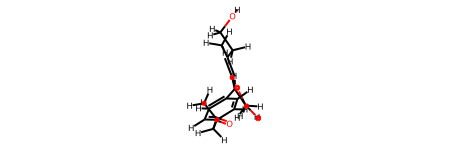

In [4]:
dataset = DockedMolsDataset("targetdiff", docked=True)
dataset.prepare_sdf(None, idx=1)[0]

In [36]:
targetdiff_generated = DockedMolsDataset("targetdiff", docked=False)
targetdiff_docked = DockedMolsDataset("targetdiff", docked=True)

crossdocked_generated = DockedMolsDataset("crossdocked_test", docked=False)
crossdocked_docked = DockedMolsDataset("crossdocked_test", docked=True)

In [ ]:
def calculate_rmsds_for_dataset(generated_dataset, docked_dataset, crossdocked=False):
    rmsds = []
    rmsds_per_sample = []

    assert len(generated_dataset.data) == len(docked_dataset.data)

    for i in range(len(generated_dataset.data)):
        sample_rmsds = []

        generated_mols = generated_dataset.load_mols(idx=i)
        docked_mols = docked_dataset.load_mols(idx=i)

        for generated_mol, docked_mol in zip(generated_mols, docked_mols):
            if generated_mol is not None and docked_mol is not None:
                generated_coords = generated_mol.GetConformer().GetPositions()
                docked_coords = docked_mol.GetConformer().GetPositions()

                try:
                    rmsd = np.sqrt(np.mean((generated_coords - docked_coords) ** 2))
                    rmsds.append(rmsd)
                    sample_rmsds.append(rmsd)
                except:
                    pass

        rmsds_per_sample.append(sample_rmsds)
    return rmsds, rmsds_per_sample


rmsds, rmsds_per_sample = calculate_rmsds_for_dataset(
    targetdiff_generated, targetdiff_docked
)

In [ ]:
targetdiff_rmsds, targetdiff_rmsds_per_sample = calculate_rmsds_for_dataset(
    targetdiff_generated, targetdiff_docked
)
crossdocked_rmsds, crossdocked_rmsds_per_sample = calculate_rmsds_for_dataset(
    crossdocked_generated, crossdocked_docked, crossdocked=True
)

<Axes: >

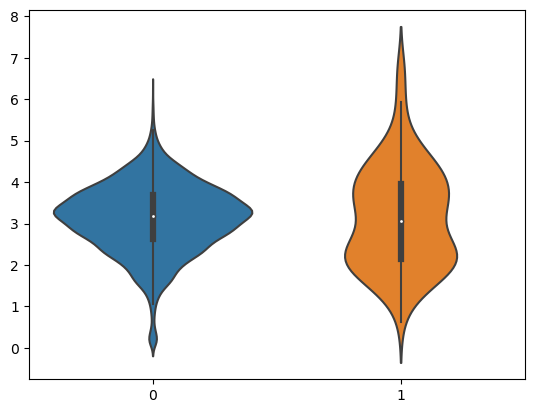

In [43]:
sns.violinplot([targetdiff_rmsds, crossdocked_rmsds])